In [1]:
# consider filtered sla to various scales 
import numpy as np
import xarray as xr
import time 
from datetime import datetime
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
import cmocean
from scipy.interpolate import interp1d 
import scipy.ndimage as si
from scipy.fftpack import fft
from tqdm.notebook import tqdm
import pickle 
from altimetry_tools import Filter, smooth_tracks, specsharp
from altimetry_tools import smooth_tracks_deg, smooth_tracks_Ld

import warnings 
warnings.filterwarnings('ignore')

# load coastlines
x4 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/bathymetry_gebco_2020/coastlines_global.nc')  

In [2]:
this_sat = 'j2'
filter_type = 'sharp'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + 'processed_vel_short.p', 'rb'))
# load_sat2 = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
#                             this_sat2 + '_' + filter_type + '_processed_vel_filtered_k_w_sq.p', 'rb'))

In [3]:
load_sat.keys()

dict_keys(['dist', 'vel', 'lon_record', 'lat_record', 'track', 'grid_spacing', 'time'])

In [4]:
# if smoothing the velocity measurements can happen on pangeo 
# dist = load_sat['dist']
# sla = load_sat['adt']
# sla_s_dict = load_sat['vel_smooth_dict']
# sla_sq_s_dict = load_sat['vel_sq_smooth_dict']
# lon_record = load_sat['lon_record']
# lat_record = load_sat['lat_record']
# track_record = load_sat['track']
# time_record = load_sat['time']
# coarse_fac_k = load_sat['coarsening_factor_k']
# hor_grid_spacing = dist[0][1] - dist[0][0]
# coarse_fac = coarse_fac_k.copy()

# else
dist = load_sat['dist']
vel = load_sat['vel']
# sla = load_sat['sla']
lon_record = load_sat['lon_record']
lat_record = load_sat['lat_record']
track_record = load_sat['track']
time_record = load_sat['time']

# coarse_fac_k = load_sat['coarsening_factor_k']
# hor_grid_spacing = dist[0][1] - dist[0][0]
# coarse_fac = coarse_fac_k.copy()

# for i in range(len(coarse_fac_k)):
#     thisone = np.int(np.floor( (1/coarse_fac_k[i])/hor_grid_spacing ))
#     coarse_fac[i] = thisone*hor_grid_spacing

In [57]:
hor_grid_spacing = dist[0][1] - dist[0][0]
dx = hor_grid_spacing
L = 275                                          # = number of grid points contributing to each spectral estimate
k = np.linspace(0, 1.0/(2.0*dx), np.int(L/2))
# inn = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # OLD
# inn = [8,10,13,16,20,28,36] # OLD
# inn = [7,9,11,13,15,17,19,21,27,34,39]  * THIS IS BEST FOR COARSE USE
# k_sub = k[inn]

# ***
wavelengths = np.flip(np.concatenate((np.arange(60,310,10), np.array([400]))))
# *** 
k_sub = 1/wavelengths
coarsening_factors = np.nan * np.ones(len(k_sub))
for i in range(len(k_sub)):
    thisone =  np.round((1/k_sub[i])/hor_grid_spacing)
    print('smoothing to ' + str(thisone*hor_grid_spacing) + ' km')
    coarsening_factors[i] = thisone
coarse_fac = coarsening_factors*hor_grid_spacing
# print(coarse_fac)
print('filtering factors = ' + str(coarsening_factors) + ' ** = full width of boxcar **')

smoothing to 400.0 km
smoothing to 300.0 km
smoothing to 290.0 km
smoothing to 280.0 km
smoothing to 270.0 km
smoothing to 260.0 km
smoothing to 250.0 km
smoothing to 240.0 km
smoothing to 230.0 km
smoothing to 220.0 km
smoothing to 210.0 km
smoothing to 200.0 km
smoothing to 190.0 km
smoothing to 180.0 km
smoothing to 170.0 km
smoothing to 160.0 km
smoothing to 150.0 km
smoothing to 140.0 km
smoothing to 130.0 km
smoothing to 120.0 km
smoothing to 110.0 km
smoothing to 100.0 km
smoothing to 90.0 km
smoothing to 80.0 km
smoothing to 70.0 km
smoothing to 60.0 km
filtering factors = [40. 30. 29. 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14.
 13. 12. 11. 10.  9.  8.  7.  6.] ** = full width of boxcar **


In [58]:
# refine to generate filter bands 
filter_width = np.nan * np.ones(len(k_sub))
for i in range(len(k_sub)):
    thisone = np.round( (1/k_sub[i])/hor_grid_spacing )  # np.int(np.floor( (1/k_sub[i])/hor_grid_spacing ))
    filter_width[i] = thisone*hor_grid_spacing
    print('smoothing to ' + str(thisone*hor_grid_spacing) + ' km')
    exec(f'coarse_fac_{i} = {thisone}')
filter_band = filter_width[0:-1] + np.diff(filter_width)/2
filter_band = np.append(filter_band, (filter_width[-1] - hor_grid_spacing)/2 + hor_grid_spacing)
band_centers = filter_band
band_ends = filter_width
print(filter_band)
print(band_ends)

smoothing to 400.0 km
smoothing to 300.0 km
smoothing to 290.0 km
smoothing to 280.0 km
smoothing to 270.0 km
smoothing to 260.0 km
smoothing to 250.0 km
smoothing to 240.0 km
smoothing to 230.0 km
smoothing to 220.0 km
smoothing to 210.0 km
smoothing to 200.0 km
smoothing to 190.0 km
smoothing to 180.0 km
smoothing to 170.0 km
smoothing to 160.0 km
smoothing to 150.0 km
smoothing to 140.0 km
smoothing to 130.0 km
smoothing to 120.0 km
smoothing to 110.0 km
smoothing to 100.0 km
smoothing to 90.0 km
smoothing to 80.0 km
smoothing to 70.0 km
smoothing to 60.0 km
[350. 295. 285. 275. 265. 255. 245. 235. 225. 215. 205. 195. 185. 175.
 165. 155. 145. 135. 125. 115. 105.  95.  85.  75.  65.  35.]
[400. 300. 290. 280. 270. 260. 250. 240. 230. 220. 210. 200. 190. 180.
 170. 160. 150. 140. 130. 120. 110. 100.  90.  80.  70.  60.]


In [8]:
# IF WE WANT try combining two satellites 
# vel = load_sat['vel'] + load_sat2['vel']
# dist = load_sat['dist'] + load_sat2['dist']
# lon_record = load_sat['lon_record'] + load_sat2['lon_record']
# lat_record = load_sat['lat_record'] + load_sat2['lat_record']
# track_record = load_sat['track'] + load_sat2['track']
# time_record = load_sat['time'] + load_sat2['time']

In [9]:
# prep for partitioning into months 
year_day = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # days per month 
year_time_record = []
for i in range(len(time_record)):
    t_s = datetime.utcfromtimestamp(time_record[i][0])  # start time 
    offset_i = np.sum(year_day[0:t_s.month - 1])/365 + t_s.day/365 + t_s.hour/(365*24)  # starting time index (fractional days)
    year_time_record.append(((time_record[i] - time_record[i][0])/(60*60*24))/365 + offset_i)

In [11]:
# create sharp filter kernel for each coarsening factor
# coarsening_factors = coarse_fac/hor_grid_spacing
# nyquist_wavelength = np.pi
# filter_kernels = []
# for i in range(len(coarsening_factors)):
#     filter_kernel, jj = specsharp(hor_grid_spacing, coarsening_factors[i], nyquist_wavelength)
#     filter_kernels.append(filter_kernel)

In [59]:
# SET FILTERING PARAMETERS 
N = 75                     # filter steps (computational choice)
N_G = 20
dx = 1
LfB = coarsening_factors.copy()
LfT = LfB/2
LfG = LfB/np.sqrt(6)         # gaussian 

In [164]:
np.sqrt(12)

3.4641016151377544

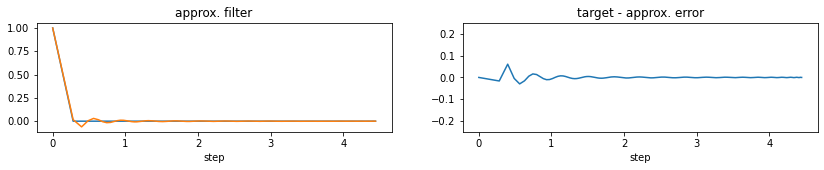

KeyboardInterrupt: 

In [33]:
# if playing with SLA 
# SQUARE THE SLA 
sla_sq = []
for i in tqdm(range(len(sla))):
    sla_sq.append(sla[i]**2)
    
sla_smooth_dict = []
sla_sq_smooth_dict = []
# remember, coarsening factors ordered large scale to small scale 
for i in tqdm(range(len(coarsening_factors))):
    sla_filt_i = Filter(N, 'Taper', sla, dx, LfT[i], plot_filter=1)
    sla_smooth_dict.append(sla_filt_i)
    # print((i+1)/len(coarsening_factors))

In [14]:
# SLA
# -- Gaussian filter 
sla_G_dict = []
for i in tqdm(range(len(coarsening_factors))):
    sla_G_filt_i = Filter(N, 'Gaussian', sla, dx, LfG[i], plot_filter=0)  # if boxcar--> np.int(LfB[i])
    sla_G_dict.append(sla_G_filt_i)

In [60]:
# -- SMOOTH & COARSEN VELOCITY (loop over desired coarsening factors)# 
# SQUARE THE VELOCITY 
vel_sq = []
for i in tqdm(range(len(vel))):
    vel_sq.append(vel[i]**2)
vel_smooth_dict = []
vel_sq_smooth_dict = []
# remember, coarsening factors ordered large scale to small scale 
for i in tqdm(range(len(coarsening_factors))):
    vel_filt_i = Filter(N, 'Taper', vel, dx, LfT[i], plot_filter=0)  # if boxcar--> np.int(LfB[i])
    # vel_sq_filt_i = Filter(N, 'Taper', vel_sq, dx, LfT[i], plot_filter=0)
    # vel_sq_smooth_i = smooth_tracks(dist, vel_sq, track_record, coarsening_factors[i], f_type, filter_kernels[i], nyquist_wavelength, space_time)

    vel_smooth_dict.append(vel_filt_i)
    # vel_sq_smooth_dict.append(vel_sq_filt_i)
    # print((i+1)/len(coarsening_factors))

In [62]:
# -- Gaussian filter 
vel_G_dict = []
for i in tqdm(range(len(coarsening_factors))):
    vel_G_filt_i = Filter(N_G, 'Gaussian', vel, dx, LfG[i], plot_filter=0)  # if boxcar--> np.int(LfB[i])
    vel_G_dict.append(vel_G_filt_i)

In [50]:
# -- boxcar filter
vel_b_dict = []
for i in range(len(coarsening_factors)):
    vel_b_filt_i = Filter(N, 'boxcar', vel, dx, np.int(LfB[i]), plot_filter=0)  # if boxcar--> np.int(LfB[i])
    vel_b_dict.append(vel_b_filt_i)

In [42]:
# if desired filter to Ld1
# Chelton et al. 1998 'global variability of the first baroclinic rossby radius of deformation'
c98 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/global_deformation_radius_chelton_1998.nc')  
c98 = c98['values'].data
vel_filtered_Ld = smooth_tracks_Ld(dist, vel, lon_record, lat_record, hor_grid_spacing, c98)

In [93]:
# NEED TO RUN THIS CELL 
# sla variable is really the velocity (raw and filtered)...the name sla is arbitrary lol
# sla = sla  
# sla_s_dict = sla_smooth_dict      
sla = vel
sla_s_dict = vel_smooth_dict      # SHARP
sla_G_dict = vel_G_dict           # Gaussian
# sla_s_dict = vel_b_dict         # BOXCAR
# sla_sq_s_dict = vel_sq_smooth_dict # each index represents filtering to each coarsening_factor 
# (**increasing indices big to small scales**)

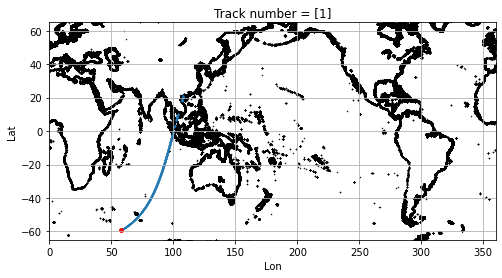

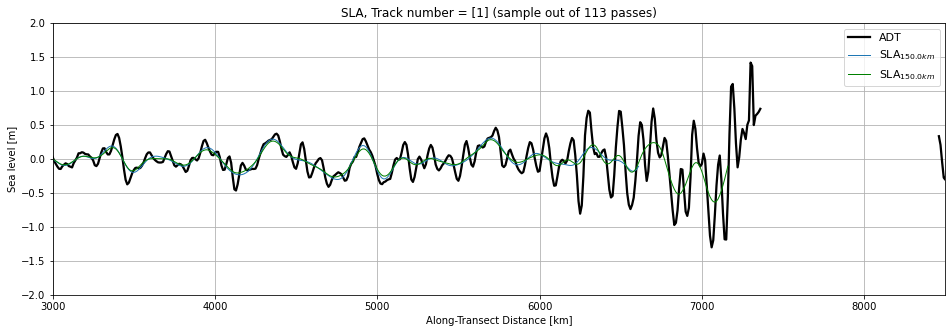

In [162]:
# -- choose a track (to show SLA, Vel, Track Location) (SAMPLE PLOT)
lon_w = 0
lon_e = 360
lat_s = -65
lat_n = 65
t_i = np.array([1])  # s3a 33 en 3 # J2 24, 176 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
pass_index = 3
save_f = 0
good_indi_dist = np.where(track_record == t_i)[0][0]

f, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
ax.scatter(lon_record[good_indi_dist], lat_record[good_indi_dist], s=0.25)
ax.scatter(lon_record[good_indi_dist][0], lat_record[good_indi_dist][0], s=15, color='r')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title('Track number = ' + str(t_i))
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_sla_track_loc', dpi=300)

f, ax = plt.subplots(1, 1, figsize = (16, 5))
# for i in range(np.shape(sla[good_indi_dist])[0]):
#     ax.plot(dist[good_indi_dist], sla[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
    
eq_region = np.where(np.abs(lat_record[good_indi_dist]) < 0.1)[0]
if len(eq_region) > 0:
    ax.plot([dist[good_indi_dist][eq_region], dist[good_indi_dist][eq_region]], [-2, 2], color='k', linestyle='--')
    ax.text(dist[good_indi_dist][eq_region][0] + 30, -0.5, 'Equator')
    
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], sla[good_indi_dist][i, :], linewidth=2.25, label=r'ADT', color='k')
    for j in [-10]:  # [0, np.int(np.round(len(coarsening_factors)/4)), -10, -4]:  # range(len(sla_s_dict)):
        ax.plot(dist[good_indi_dist], sla_s_dict[j][good_indi_dist][i, :], \
                linewidth=1, label=r'SLA$_{' + str(coarse_fac[j]) + 'km}$')
        ax.plot(dist[good_indi_dist], sla_G_dict[j][good_indi_dist][i, :], \
                linewidth=1, label=r'SLA$_{' + str(coarse_fac[j]) + 'km}$', color='g')

ax.set_xlim([3000, 8500])
ax.set_ylim([-2, 2])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('Sea level [m]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11)
ax.set_title('SLA, Track number = ' + str(t_i) + ' (sample out of ' + str(np.shape(sla[good_indi_dist])[0]) + ' passes)')
ax.grid()
plt.show()
# if save_f:
# f.savefig(this_sat + '_sla_sample_track', dpi=300)

In [17]:
lon_w = 0
lon_e = 360
lat_s = -60
lat_n = 60

# lat/lon key
for i in range(len(lon_record)):
    if i < 1:
        lon_t = lon_record[i]
        lat_t = lat_record[i]
        track_t = np.ones(len(lon_record[i])) * track_record[i]
    else:
        lon_t = np.concatenate((lon_t, lon_record[i]))
        lat_t = np.concatenate((lat_t, lat_record[i]))    
        track_t = np.concatenate((track_t, np.ones(len(lon_record[i])) * track_record[i]))

In [94]:
# statistics from un-filtered data (set binning parameters)
step = 1
lon_win = 6 # 2.5
lat_win = 6 # 2.5
lon_bins = np.arange(lon_w, lon_e + step, step)
lat_bins = np.arange(lat_s, lat_n + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2
thresh = 25
mean_sla_total = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]     
        this_lon0 = this_lon - lon_win/2
        this_lon1 = this_lon + lon_win/2
        this_lat0 = this_lat - lat_win/2
        this_lat1 = this_lat + lat_win/2
        
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & \
                            (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1) & \
                            (np.abs(lat_record[ai[tib]]) > 5))[0]
            if count < 1:
                sla_total_i = sla[ai[tib]][:, inn2].flatten()
                count = count + 1
            else:
                sla_total_i = np.append(sla_total_i, sla[ai[tib]][:, inn2].flatten())
        if (len(ai) > 1):
            if (len(sla_total_i) > thresh):
                mean_sla_total[i, j] = np.nanmean(sla_total_i**2)              # non-seasonal
        ai = 0

In [95]:
# ALONG-TRACK ---> 2d MAP 
# -- goal to calculate variance at each scale as a function of season 
# -- seasonal/monthly increments 
# twelve increments 
months = np.concatenate((np.array([0]), (np.cumsum(np.array([year_day])))))/365
s_i = np.concatenate((months[0:-1][:, None], months[1:][:, None]), axis=1) 

# initialize arrays  
mean_sla0 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_sla_check = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_sla_smoothG = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_sla_smoothB = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))

mean_sla_sq_smooth3 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_sla_sq_smooth13 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))

mean_diff0 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_diff0_3 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_diff0_13 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_diffG_3 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_diffG_13 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_diffb_3 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_diffb_13 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))

for tt in range(len(s_i)):                        # month 
    for i in tqdm(range(1, len(lon_bin_c) - 1)):  # lon
        for j in range(1, len(lat_bin_c) - 1):    # lat
        
            this_lon = lon_bin_c[i]
            this_lat = lat_bin_c[j]     
            this_lon0 = this_lon - lon_win/2
            this_lon1 = this_lon + lon_win/2
            this_lat0 = this_lat - lat_win/2
            this_lat1 = this_lat + lat_win/2
        
            inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
            # tracks that fall within this box 
            [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
            countf = 0
            filters = {}
            filtersG = {}
            filtersB = {}
            for tib in range(len(ai)):
                # for each track that crosses through box, again find subset of grid points in box 
                inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & \
                                (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1) & \
                                (np.abs(lat_record[ai[tib]]) > 5))[0]
                # time bin 
                this_time = np.mod(year_time_record[ai[tib]], 1)
                time_in = np.where((this_time > s_i[tt, 0]) & (this_time < s_i[tt, 1]))[0]
                
                # loop over each filter scale (ORDER large to small)   
                if countf < 1:
                    sla_i = sla[ai[tib]][time_in][:, inn2].flatten()                         # raw
                    sla_total_i = sla[ai[tib]][:, inn2].flatten()
                    # sla_smooth_check = sla_s_dict[10][ai[tib]][time_in][:, inn2].flatten() 
                    for ff in range(len(coarsening_factors)):  
                        filters[coarsening_factors[ff]] = sla_s_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                        filtersG[coarsening_factors[ff]] = sla_G_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                        # filtersB[coarsening_factors[ff]] = vel_b_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                    countf = countf + 1
                else:
                    sla_i = np.append(sla_i, sla[ai[tib]][time_in][:, inn2].flatten())
                    sla_total_i = np.append(sla_total_i, sla[ai[tib]][:, inn2].flatten())
                    # sla_smooth_check = np.append(sla_smooth_check, sla_s_dict[10][ai[tib]][time_in][:, inn2].flatten())
                    for ff in range(len(coarsening_factors)):  # range(len(coarsening_factors)-1, -1, -1):
                        filters[coarsening_factors[ff]] = np.concatenate((filters[coarsening_factors[ff]], sla_s_dict[ff][ai[tib]][time_in][:, inn2].flatten()))
                        filtersG[coarsening_factors[ff]] = np.concatenate((filtersG[coarsening_factors[ff]], sla_G_dict[ff][ai[tib]][time_in][:, inn2].flatten()))
                        # filtersB[coarsening_factors[ff]] = np.concatenate((filtersB[coarsening_factors[ff]], vel_b_dict[ff][ai[tib]][time_in][:, inn2].flatten()))
            
                # if count < 1:
                    # sla_i = sla[ai[tib]][time_in][:, inn2].flatten()                         # raw
                    # sla_total_i = sla[ai[tib]][:, inn2].flatten()
                    
                    # sla_smooth_3_i = sla_s_dict[10][ai[tib]][time_in][:, inn2].flatten()      # smallest
                    # sla_smooth_13_i = sla_s_dict[0][ai[tib]][time_in][:, inn2].flatten()     # largest 
                    # - gaussian 
                    # vG_smooth_3_i = vel_G_dict[10][ai[tib]][time_in][:, inn2].flatten()      # smallest
                    # vG_smooth_13_i = vel_G_dict[0][ai[tib]][time_in][:, inn2].flatten()     # largest 
                    # - boxcar
                    # vb_smooth_3_i = vel_b_dict[10][ai[tib]][time_in][:, inn2].flatten()      # smallest
                    # vb_smooth_13_i = vel_b_dict[0][ai[tib]][time_in][:, inn2].flatten()     # largest 
                    # count = count + 1
                # else:
                    # sla_i = np.append(sla_i, sla[ai[tib]][time_in][:, inn2].flatten())
                    # sla_total_i = np.append(sla_total_i, sla[ai[tib]][:, inn2].flatten())
                    # sla_smooth_3_i = np.append(sla_smooth_3_i, sla_s_dict[10][ai[tib]][time_in][:, inn2].flatten())
                    # sla_smooth_13_i = np.append(sla_smooth_13_i, sla_s_dict[0][ai[tib]][time_in][:, inn2].flatten())                  
                    # vG_smooth_3_i = np.append(vG_smooth_3_i, vel_G_dict[10][ai[tib]][time_in][:, inn2].flatten())
                    # vG_smooth_13_i = np.append(vG_smooth_13_i, vel_G_dict[0][ai[tib]][time_in][:, inn2].flatten())            
                    # vb_smooth_3_i = np.append(vb_smooth_3_i, vel_b_dict[10][ai[tib]][time_in][:, inn2].flatten())
                    # vb_smooth_13_i = np.append(vb_smooth_13_i, vel_b_dict[0][ai[tib]][time_in][:, inn2].flatten())
            
            # average in this lat/lon box 
            if countf > 0:  # (len(ai) > 1):
                if (len(sla_i) > thresh):
                    # -- unfiltered eddy energy estimate (highest resolution)
                    mean_sla0[tt, i, j] = np.nanmean(sla_i**2)  
                    #mean_sla_check[tt,i,j] = np.nanmean(sla_smooth_check**2)
                    
                    # ORDER = large to small 
                    for cf in range(len(coarsening_factors)):
                        # -- large scale (\overline{\eta}^2) (filtering of the quantity, then squaring)
                        mean_sla_smooth[tt,i,j,cf] = np.nanmean(filters[coarsening_factors[cf]]**2)
                        mean_sla_smoothG[tt,i,j,cf] = np.nanmean(filtersG[coarsening_factors[cf]]**2)
                        # mean_sla_smoothB[tt,i,j,cf] = np.nanmean(filtersB[coarsening_factors[cf]]**2)
                        # - SHARP -- EKE w/o filtering the squared velocity 
                        mean_diff0[tt,i,j,cf] = np.nanmean(sla_i**2 - filters[coarsening_factors[cf]]**2) 
                    
                    # mean_sla_smooth3[tt, i, j] = np.nanmean(sla_smooth_3_i**2)      
                    # mean_sla_smooth13[tt, i, j] = np.nanmean(sla_smooth_13_i**2)   
                    
                    # -- large scale (\overline{\eta^2}) (filtering of the squared quantity)
                    # mean_sla_sq_smooth3[tt, i, j] = np.nanmean(sla_sq_smooth_3_i)     # example

                    # -- EKE  
                    # mean_diff0_3[tt, i, j] = np.nanmean((sla_sq_smooth_3_i - sla_smooth_3_i**2))
                    # mean_diff0_13[tt, i, j] = np.nanmean((sla_sq_smooth_13_i - sla_smooth_13_i**2))
                    
                    # - SHARP -- eke w/o filtering the squared velocity                    
                    # mean_diff0_3[tt, i, j] = np.nanmean((sla_i**2 - sla_smooth_3_i**2))
                    # mean_diff0_13[tt, i, j] = np.nanmean((sla_i**2 - sla_smooth_13_i**2))
                    
                    # - GAUSSIAN -- eke w/o filtering the squared velocity  
                    # mean_diffG_3[tt, i, j] = np.nanmean((sla_i**2 - vG_smooth_3_i**2))
                    # mean_diffG_13[tt, i, j] = np.nanmean((sla_i**2 - vG_smooth_13_i**2))
                    
                    # - BOXCAR -- eke w/o filtering the squared velocity 
                    # mean_diffb_3[tt, i, j] = np.nanmean((sla_i**2 - vb_smooth_3_i**2))
                    # mean_diffb_13[tt, i, j] = np.nanmean((sla_i**2 - vb_smooth_13_i**2))
            ai = 0

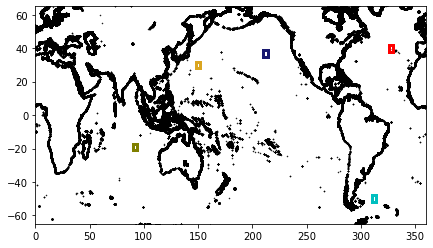

In [155]:
# pick locations and look at a time series of EKE 
frac_year = np.nan*np.ones(len(s_i))
for i in range(len(s_i)):
    frac_year[i] = np.nanmean(s_i[i])
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
colors = ['#191970', '#DAA520', '#808000', 'r', 'c', 'm']
order = ['Eastern N. Pac.', 'Kuroshio', 'Indian', 'N. Atl.', 'ACC', 'Gulf Stream']
location = np.array([[210, 214, 35, 39], [148, 152, 28, 32], [90, 94, -21, -17], \
                     [326, 330, 38, 42], [310, 314, -52, -48], [290, 294, 30, 34]])
# alternate set of locations to play with 
# order = ['Eastern Eq. Pac.', 'N. N. Pacific', 'S. E. Pac', 'N. Atl.', 'ACC2', 'Gulf Stream']
# location = np.array([[210, 214, 16, 20], [196, 200, 46, 50], [250, 254, -21, -17], \
#                      [310, 314, 42, 46], [98, 102, -52, -48], [290, 294, 30, 34]])

f, ax = plt.subplots(1,1, figsize = (7,4))
ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
for i in range(len(order[0:5])):
    this_lon0 = location[i, 0] #90   # 210
    this_lon1 = location[i, 1] #94   # 214
    this_lat0 = location[i, 2] #-22  # 35
    this_lat1 = location[i, 3] #-18  # 39
    ax.plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors[i], linewidth=3)
    ax.plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors[i], linewidth=3)
    ax.plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    ax.plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors[i], linewidth=3)
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
plt.show()

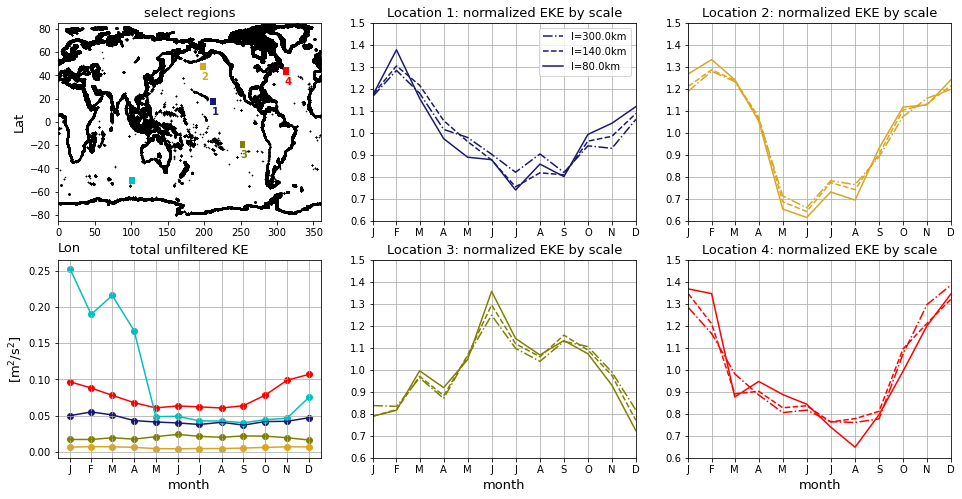

In [151]:
# seasonality in EKE 
f, ax = plt.subplots(2, 3, figsize = (16, 8))
ax[0,0].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
in_lon = []
in_lat = []
for i in range(len(order[0:5])):
    this_lon0 = location[i, 0] #90   # 210
    this_lon1 = location[i, 1] #94   # 214
    this_lat0 = location[i, 2] #-22  # 35
    this_lat1 = location[i, 3] #-18  # 39
    ax[0,0].plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    if i < 4:
        ax[0,0].text(this_lon0, this_lat0 - 10, str(i + 1), fontsize=10, color=colors[i], fontweight='bold')
    in_lon.append(np.where((lon_bin_c > this_lon0) & (lon_bin_c < this_lon1))[0])
    in_lat.append(np.where((lat_bin_c > this_lat0) & (lat_bin_c < this_lat1))[0])

ax[0,0].set_xlim([lon_w, lon_e])
ax[0,0].set_ylim([lat_s - 20, lat_n + 20])
ax[0,0].set_xlabel('Lon', fontsize=13, horizontalalignment='left', x=0.0)
ax[0,0].set_ylabel('Lat', fontsize=13)
ax[0,0].set_title('select regions', fontsize=13)
ax[0,0].grid()

for i in range(5):
    ax[1,0].plot(frac_year, np.nanmean(mean_sla0[:, in_lon[i]][:, :, in_lat[i]], axis=tuple(range(1, 3))), color=colors[i], label=order[i])  # np.nanmean(np.nanmean(np.nanmean(mean_sla0[:, in1_lon][:, :, in1_lat], axis=1), axis=1))
    ax[1,0].scatter(frac_year, np.nanmean(mean_sla0[:, in_lon[i]][:, :, in_lat[i]], axis=tuple(range(1, 3))), color=colors[i])
    # std of total ke at each site 
    if (i == 1):  #  | (i == 2):
        for j in range(len(frac_year)):
            site_mean = np.nanmean(mean_sla0[j][in_lon[i], :][:, in_lat[i]])
            # ax[1,0].plot([frac_year[j]+(i*0.005), frac_year[j]+(i*0.005)], \
            #              [site_mean - np.nanstd(mean_sla0[j][in_lon[i], :][:, in_lat[i]]), \
            #               site_mean + np.nanstd(mean_sla0[j][in_lon[i], :][:, in_lat[i]])], color=colors[i])
ax[1,0].set_ylabel('[m$^2$/s$^2$]', fontsize=13)
ax[1,0].set_title('total unfiltered KE', fontsize=13)

# loop over each site, plot time series for three filtering scales 
to_show = np.where((coarsening_factors == 8) | (coarsening_factors == 14) | (coarsening_factors == 30))[0]
axi=[[0,1], [0,2], [1,1], [1,2]]
for i in range(4):
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]], axis=tuple(range(1, 3)))/\
                 np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[0]]*10) + 'km', linestyle='-.')
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]], axis=tuple(range(1, 3)))/\
                 np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[1]]*10) + 'km', linestyle='--')
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]], axis=tuple(range(1, 3)))/\
                 np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[2]]*10) + 'km')
    
    # -- time series of eke within lat/lon bounds for largest/smallest coarsening_factor 
    # std deviation 
    # site_mean_smallestcf = mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]]
    # site_mean_largestcf = mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]]
    # low0 = np.nan * np.ones(len(frac_year))
    # high0 = np.nan * np.ones(len(frac_year))
    # low1 = np.nan * np.ones(len(frac_year))
    # high1 = np.nan * np.ones(len(frac_year))
    # for j in range(len(frac_year)):
    #     low0[j] = [np.nanmean(site_mean_smallestcf[j][:, :]) - np.nanstd(site_mean_smallestcf[j][:, :])]/np.nanmean(site_mean_smallestcf)
    #     high0[j] = [np.nanmean(site_mean_smallestcf[j][:, :]) + np.nanstd(site_mean_smallestcf[j][:, :])]/np.nanmean(site_mean_smallestcf)
    #     low1[j] = [np.nanmean(site_mean_largestcf[j][:, :]) - np.nanstd(site_mean_largestcf[j][:, :])]/np.nanmean(site_mean_largestcf)
    #     high1[j] = [np.nanmean(site_mean_largestcf[j][:, :]) + np.nanstd(site_mean_largestcf[j][:, :])]/np.nanmean(site_mean_largestcf)
    # ax[axi[i][0], axi[i][1]].fill_between(frac_year, low0, high0, color=colors[i], alpha=0.3)
    # ax[axi[i][0], axi[i][1]].fill_between(frac_year, low1, high1, color=colors[i], alpha=0.3)

# OLD framework 
# ax[0,1].plot(frac_year, np.nanmean(np.nanmean(mean_diff0_4[:, in_lon[0]][:, :, in_lat[0]], axis=1), axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_4[:, in_lon[0]][:, :, in_lat[0]], axis=1), axis=1)), \
#              color=colors[0], label='l=' + str(coarse_fac[9]) + 'km')
# ax[0,2].plot(frac_year, np.nanmean(np.nanmean(mean_diff0_4[:, in_lon[1]][:, :, in_lat[1]], axis=1), axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_4[:, in_lon[1]][:, :, in_lat[1]], axis=1), axis=1)), color=colors[1])
# ax[0,1].plot(frac_year, np.nanmean(np.nanmean(mean_diff0_7[:, in_lon[0]][:, :, in_lat[0]], axis=1), axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_7[:, in_lon[0]][:, :, in_lat[0]], axis=1), axis=1)), \
#              color=colors[0], linestyle='--', label='l=' + str(coarse_fac[6]) + 'km')
# ax[0,2].plot(frac_year, np.nanmean(np.nanmean(mean_diff0_7[:, in_lon[1]][:, :, in_lat[1]], axis=1), axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_7[:, in_lon[1]][:, :, in_lat[1]], axis=1), axis=1)), color=colors[1], linestyle='--')
# ax[0,1].plot(frac_year, np.nanmean(np.nanmean(mean_diff0_12[:, in_lon[0]][:, :, in_lat[0]], axis=1), axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_12[:, in_lon[0]][:, :, in_lat[0]], axis=1), axis=1)), \
#              color=colors[0], linestyle='-.', label='l=' + str(coarse_fac[1]) + 'km')
# ax[0,2].plot(frac_year, np.nanmean(np.nanmean(mean_diff0_12[:, in_lon[1]][:, :, in_lat[1]], axis=1), axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_12[:, in_lon[1]][:, :, in_lat[1]], axis=1), axis=1)), color=colors[1], linestyle='-.')

ax[0,1].set_title('Location 1: normalized EKE by scale', fontsize=13)
ax[0,2].set_title('Location 2: normalized EKE by scale', fontsize=13)
ax[1,1].set_title('Location 3: normalized EKE by scale', fontsize=13)
ax[1,2].set_title('Location 4: normalized EKE by scale', fontsize=13)

ax[0,1].set_xticks(frac_year)
ax[0,1].set_xticklabels(month_labels)
# ax[0,1].set_xlabel('month', fontsize=13)
ax[0,2].set_xticks(frac_year)
ax[0,2].set_xticklabels(month_labels)

ax[1,0].set_xticks(frac_year)
ax[1,0].set_xticklabels(month_labels)
ax[1,0].set_xlabel('month', fontsize=13)

ax[1,1].set_xticks(frac_year)
ax[1,1].set_xticklabels(month_labels)
ax[1,1].set_xlabel('month', fontsize=13)

ax[1,2].set_xticks(frac_year)
ax[1,2].set_xticklabels(month_labels)
ax[1,2].set_xlabel('month', fontsize=13)

# ax[1,0].set_ylabel('[m$^2$/s$^2$]')
handles, labels = ax[0,1].get_legend_handles_labels()
ax[0,1].legend(handles, labels, fontsize=10)

ax[0,1].set_xlim([frac_year[0], frac_year[-1]])
ax[0,2].set_xlim([frac_year[0], frac_year[-1]])
ax[1,1].set_xlim([frac_year[0], frac_year[-1]])
ax[1,2].set_xlim([frac_year[0], frac_year[-1]])
ax[0,1].set_ylim([0.6, 1.5])
ax[0,2].set_ylim([0.6, 1.5])
ax[1,1].set_ylim([0.6, 1.5])
ax[1,2].set_ylim([0.6, 1.5])
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_by_month.jpg', dpi=400)

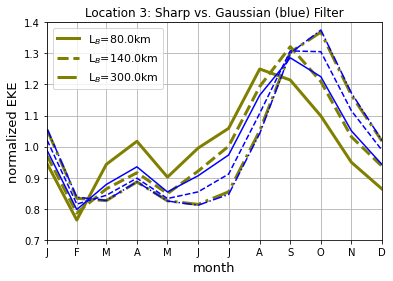

In [60]:
# compare three filters at one location 
f, ax = plt.subplots(1,1)
ax.plot(frac_year, np.nanmean(np.nanmean(mean_diff0_4[:, in_lon[2]][:, :, in_lat[2]], axis=1), \
                              axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_4[:, in_lon[2]][:, :, in_lat[2]], axis=1), axis=1)), color=colors[2], label='L$_B$=' + str(coarse_fac[9]) + 'km', linewidth=3)
ax.plot(frac_year, np.nanmean(np.nanmean(mean_diff0_7[:, in_lon[2]][:, :, in_lat[2]], axis=1), \
                              axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_7[:, in_lon[2]][:, :, in_lat[2]], axis=1), axis=1)), color=colors[2], linestyle='--', label='L$_B$=' + str(coarse_fac[6]) + 'km', linewidth=3)
ax.plot(frac_year, np.nanmean(np.nanmean(mean_diff0_12[:, in_lon[2]][:, :, in_lat[2]], axis=1), \
                              axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diff0_12[:, in_lon[2]][:, :, in_lat[2]], axis=1), axis=1)), color=colors[2], linestyle='-.', label='L$_B$=' + str(coarse_fac[1]) + 'km', linewidth=3)
ax.plot(frac_year, np.nanmean(np.nanmean(mean_diffG_4[:, in_lon[2]][:, :, in_lat[2]], axis=1), \
                              axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diffG_4[:, in_lon[2]][:, :, in_lat[2]], axis=1), axis=1)), color='b')
ax.plot(frac_year, np.nanmean(np.nanmean(mean_diffG_7[:, in_lon[2]][:, :, in_lat[2]], axis=1), \
                              axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diffG_7[:, in_lon[2]][:, :, in_lat[2]], axis=1), axis=1)), color='b', linestyle='--')
ax.plot(frac_year, np.nanmean(np.nanmean(mean_diffG_12[:, in_lon[2]][:, :, in_lat[2]], axis=1), \
                              axis=1)/np.nanmean(np.nanmean(np.nanmean(mean_diffG_12[:, in_lon[2]][:, :, in_lat[2]], axis=1), axis=1)), color='b', linestyle='-.')
ax.set_xlim([frac_year[0], frac_year[-1]])
ax.set_ylim([0.7, 1.4])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11, loc='upper left')
ax.set_xticks(frac_year)
ax.set_xticklabels(month_labels)
ax.set_xlabel('month', fontsize=13)
ax.set_ylabel('normalized EKE', fontsize=13)
ax.set_title('Location 3: Sharp vs. Gaussian (blue) Filter')
ax.grid()
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_indian_sharp_v_gauss_.jpg', dpi=400)

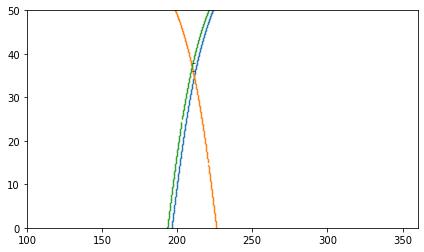

In [72]:
# check sample box and paths that fall within (and look at local scattering of eke vs. KE)
this_lon0 = 298
this_lon1 = 300
this_lon0 = 210
this_lon1 = 212
this_lat0 = 36
this_lat1 = 38
inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
[ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)

fi_1 = 6
fi_2 = 4
count = 0
count2 = 0
f, ax = plt.subplots(1,1,figsize=(7,4))
for tib in range(len(ai)):
    inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1))[0]
    if count < 1:
        sla_i = sla[ai[tib]][:, inn2].flatten()
        sla_smooth_100_i = sla_s_dict[fi_1][ai[tib]][:, inn2].flatten() 
        sla_sq_smooth_100_i = sla_sq_s_dict[fi_1][ai[tib]][:, inn2].flatten() 
        sla_smooth_101_i = sla_s_dict[fi_2][ai[tib]][:, inn2].flatten() 
        sla_sq_smooth_101_i = sla_sq_s_dict[fi_2][ai[tib]][:, inn2].flatten() 
        count = count + 1
    else:
        sla_i = np.append(sla_i, sla[ai[tib]][:, inn2].flatten())
        sla_smooth_100_i = np.append(sla_smooth_100_i, sla_s_dict[fi_1][ai[tib]][:, inn2].flatten())
        sla_sq_smooth_100_i = np.append(sla_sq_smooth_100_i, sla_sq_s_dict[fi_1][ai[tib]][:, inn2].flatten())
        sla_smooth_101_i = np.append(sla_smooth_101_i, sla_s_dict[fi_2][ai[tib]][:, inn2].flatten())
        sla_sq_smooth_101_i = np.append(sla_sq_smooth_101_i, sla_sq_s_dict[fi_2][ai[tib]][:, inn2].flatten())
    
    if count2 < 1:
        ke_check = sla_i**2
        eke_check_100 = sla_sq_smooth_100_i - sla_smooth_100_i**2
        eke_check_101 = sla_sq_smooth_101_i - sla_smooth_101_i**2
        eke_mke_100 = (sla_sq_smooth_100_i - sla_smooth_100_i**2)/(sla_smooth_100_i**2)
        eke_mke_101 = (sla_sq_smooth_101_i - sla_smooth_101_i**2)/(sla_smooth_101_i**2)
        count2 = 1
    else:
        ke_check = np.concatenate((ke_check, sla_i**2))
        eke_check_100 = np.concatenate((eke_check_100, (sla_sq_smooth_100_i - sla_smooth_100_i**2)))
        eke_check_101 = np.concatenate((eke_check_101, (sla_sq_smooth_101_i - sla_smooth_101_i**2)))
        eke_mke_100 = np.concatenate((eke_mke_100, (sla_sq_smooth_100_i - sla_smooth_100_i**2)/(sla_smooth_100_i**2)))
        eke_mke_101 = np.concatenate((eke_mke_101, (sla_sq_smooth_101_i - sla_smooth_101_i**2)/(sla_smooth_101_i**2)))
    ax.scatter(lon_record[ai[tib]], lat_record[ai[tib]], s=0.1)
    
ax.plot([this_lon0, this_lon1],[this_lat0, this_lat0], color='k', linewidth=0.5)
ax.plot([this_lon0, this_lon1],[this_lat1, this_lat1], color='k', linewidth=0.5)
ax.set_xlim([100, lon_e])
ax.set_ylim([0, 50])
plt.show()

In [43]:
# if we filter by Ld1, now make a global map 
mean_eke_leq_Ld1 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):       
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]     
        this_lon0 = this_lon - lon_win/2
        this_lon1 = this_lon + lon_win/2
        this_lat0 = this_lat - lat_win/2
        this_lat1 = this_lat + lat_win/2      
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & \
                            (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1) & \
                            (np.abs(lat_record[ai[tib]]) > 5))[0]
            if count < 1:
                vel_ld1_i = vel_filtered_Ld[ai[tib]][:, inn2].flatten()
                sla_total_i = sla[ai[tib]][:, inn2].flatten()
                count = count + 1
            else:
                vel_ld1_i = np.append(vel_ld1_i, vel_filtered_Ld[ai[tib]][:, inn2].flatten())
                sla_total_i = np.append(sla_total_i, sla[ai[tib]][:, inn2].flatten())
        if (len(ai) > 1):
            if (len(vel_ld1_i) > thresh):
                mean_eke_leq_Ld1[i, j] = np.nanmean(sla_total_i**2 -vel_ld1_i**2)              
        ai = 0

In [113]:
# frac ke in mesoscale band
summer = [.6, 0.85]
winter = [0.18, 0.4]
sum_in = np.where((s_i[:, 0] >= summer[0]) & (s_i[:, 0] < summer[1]))[0]
win_in = np.where((s_i[:, 0] >= winter[0]) & (s_i[:, 0] < winter[1]))[0]

meso_band_i = np.where((coarsening_factors <= 25) & (coarsening_factors >= 8))[0]
submeso_band_i = np.where(coarsening_factors <= 8)[0]

# loop over lat/lon bins 
loc_var_all = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_var_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_var_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_tot_var_all = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
loc_tot_var_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
loc_tot_var_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
submeso_frac = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]
        
        this_lon0 = this_lon - 0.5  # lon_win/2
        this_lon1 = this_lon + 0.5  # lon_win/2
        this_lat0 = this_lat - 0.5  # lat_win/2
        this_lat1 = this_lat + 0.5  # lat_win/2
        
        ll = np.where((lat_bin_c > (this_lat0 - 0)) & (lat_bin_c < (this_lat1 + 0)))[0]
        kk = np.where((lon_bin_c > (this_lon0 - 0)) & (lon_bin_c < (this_lon1 + 0)))[0]
        # ordered (large to small)
        loc_var_all[i, j, :] = np.nanmean(mean_sla_smooth[:][:, kk, :, :][:, :, ll, :], axis=0)  # tuple(range(0, 3))
        loc_var_win[i, j, :] = np.nanmean(mean_sla_smooth[win_in][:, kk, :, :][:, :, ll, :], axis=0)
        loc_var_sum[i, j, :] = np.nanmean(mean_sla_smooth[sum_in][:, kk, :, :][:, :, ll, :], axis=0)
        loc_tot_var_all[i, j] = np.nanmean(mean_sla0[:][:, kk, :][:, :, ll])
        loc_tot_var_win[i, j] = np.nanmean(mean_sla0[win_in][:, kk, :][:, :, ll])
        loc_tot_var_sum[i, j] = np.nanmean(mean_sla0[sum_in][:, kk, :][:, :, ll])
        
        # --fraction of ke within desired bounds 
        this_spec = loc_var_all[i, j, :][None, :]
        this_spec_win = loc_var_win[i, j, :][None, :]
        this_spec_sum = loc_var_sum[i, j, :][None, :]
        
        sample_band = (this_spec[0, 1:] - this_spec[0, 0:-1])  
        sample_band_win = (this_spec_win[0, 1:] - this_spec_win[0, 0:-1])
        sample_band_sum = (this_spec_sum[0, 1:] - this_spec_sum[0, 0:-1])
        
        meso_frac[i,j] = np.sum(sample_band[meso_band_i[0:-1]])/loc_tot_var_all[i, j] 
        smallest_eke = loc_tot_var_all[i,j] - this_spec[0,-1]
        submeso_frac[i,j] = np.sum(sample_band[submeso_band_i[0:-1]])/loc_tot_var_all[i, j] # variance at 100-60km
        smaller_frac_win[i,j] = np.sum(sample_band_win[meso_band_i])/loc_tot_var_win[i, j] 
        smaller_frac_sum[i,j] = np.sum(sample_band_sum[meso_band_i])/loc_tot_var_sum[i, j] 
        

In [16]:
c98 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/global_deformation_radius_chelton_1998.nc') 
c98_1 = c98['values'].data
def_rad = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
rhines = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
for i in range(len(lat_bin_c)):
    for j in range(len(lon_bin_c)):
        c_in = np.where((c98_1[:, 0] > (lat_bin_c[i] - 2)) & (c98_1[:, 0] < (lat_bin_c[i] + 2)) & \
                 (c98_1[:, 1] > (lon_bin_c[j] - 2)) & (c98_1[:, 1] < (lon_bin_c[j] + 2)))[0]
        if len(c_in) > 1:
            def_rad[i, j] = np.nanmean(c98_1[c_in, 3])
        beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_bin_c[i]))/(6356752)
        rhines[i, j] = np.sqrt(np.sqrt(mean_sla_total[j,i])/beta)

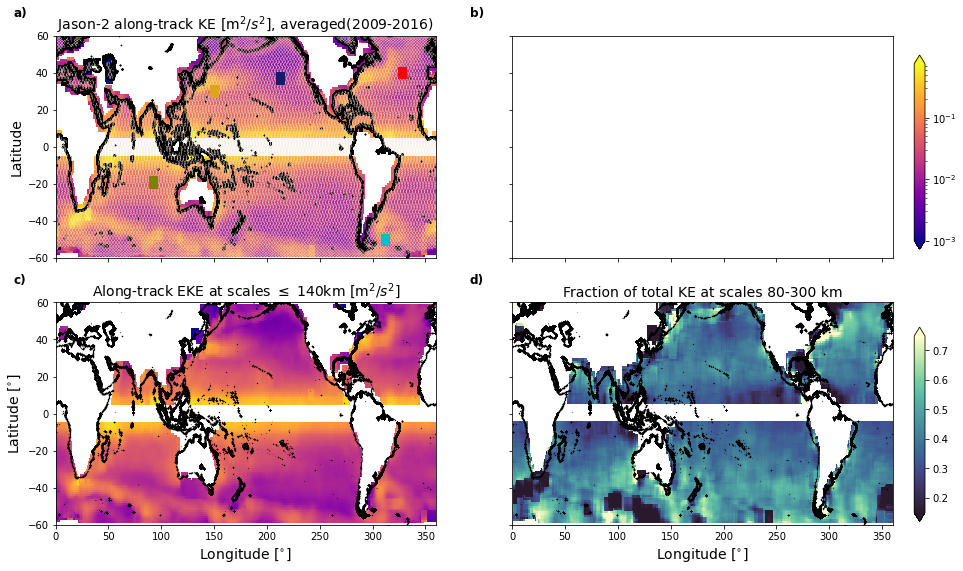

In [106]:
land_col = '#D3D3D3'
lev1 = np.arange(0.001, 0.75, 0.001)
lev2 = np.arange(0.15, 0.75, 0.001)
dlev1 = np.arange(1, 1001, 1)
tcmap = plt.get_cmap('plasma')
tcmap2 = plt.get_cmap('plasma')
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]

# -- unfiltered KE 
mean_raw_mask = np.nanmean(mean_sla0,axis=0)       
# -- EKE 
mean_eke1_mask = np.squeeze(np.nanmean(mean_diff0[:, :, :, np.where(coarsening_factors==30)[0]], axis=0)) 
# -- EKE LD1
# mean_eke2_mask = mean_eke_leq_Ld1.copy()            # EKE <= Ld1
# -- EKE 80-180km
mean_mf_mask = meso_frac.copy()                    
mean_submf_mask = submeso_frac.copy() 

mean_raw_mask[:, v_in] = np.nan
mean_eke1_mask[:, v_in] = np.nan
# mean_eke2_mask[:, v_in] = np.nan
mean_mf_mask[:, v_in] = np.nan
mean_submf_mask[:, v_in] = np.nan

f, ax = plt.subplots(2,2,figsize=(15,9),sharex=True, sharey=True)
ax[0,0].scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
ax[0,0].scatter(x4['lon'].values, x4['lat'].values, s=0.5, color='k')
axp = ax[0,0].pcolor(lon_bins, lat_bins, np.transpose(mean_raw_mask), \
                 norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), zorder=0, cmap=tcmap)
ax[0,0].set_title(r"Jason-2 along-track KE [m$^2$/$s^2$], averaged(2009-2016)", fontsize=14)
ax[0,0].set_ylabel('Latitude', fontsize=14)
for i in range(len(lon_record)):
    ax[0,0].scatter(lon_record[i][::4], lat_record[i][::4], color='#FAEBD7', zorder=1, s=0.01)
for i in range(len(order[0:5])):
    this_lon0 = location[i, 0] #90   # 210
    this_lon1 = location[i, 1] #94   # 214
    this_lat0 = location[i, 2] #-22  # 35
    this_lat1 = location[i, 3] #-18  # 39
    ax[0,0].plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors[i], linewidth=5)
    ax[0,0].plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors[i], linewidth=5)
    ax[0,0].plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors[i], linewidth=5)
    ax[0,0].plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors[i], linewidth=5)

ax[1,0].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
axp = ax[1,0].pcolor(lon_bins, lat_bins, np.transpose(mean_eke1_mask), \
                 norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), zorder=0, cmap=tcmap)
ax[1,0].set_title(r"Along-track EKE at scales $\leq$ 140km [m$^2$/$s^2$]", fontsize=14)
ax[1,0].set_ylabel('Latitude [$^{\circ}$]', fontsize=14)
ax[1,0].set_xlabel('Longitude [$^{\circ}$]', fontsize=14)

# Ld1 
# ax[0,1].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
# axp = ax[0,1].pcolor(lon_bins, lat_bins, np.transpose(mean_eke2_mask), \
#                  norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), zorder=0, cmap=tcmap)
# ax[0,1].set_title(r"Along-track EKE at scales $\leq$ $L_{d1}$ [m$^2$/$s^2$]", fontsize=14)
# dr = ax[0,1].contour(lon_bin_c, lat_bin_c, def_rad, \
#                  levels=[25, 50, 100], colors='w', linewidths=1, zorder=2)
# ax[0,1].clabel(dr, fontsize=9, inline=1, fmt = '%1.0f')

# KE frac
ax[1,1].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
axpmf = ax[1,1].pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_mf_mask), \
                 vmin=lev2[0], vmax=lev2[-1], zorder=0, cmap=cmocean.cm.deep_r)
# ax[1,1].set_title(r"Fraction of total KE at scales 80-200 km [m$^2$/$s^2$]", fontsize=14)
ax[1,1].set_title(r"Fraction of total KE at scales 80-300 km", fontsize=14)
ax[1,1].set_xlabel('Longitude [$^{\circ}$]', fontsize=14)

ax[0,0].set_xlim([lon_w, lon_e])
ax[0,0].set_ylim([lat_s+5, lat_n-5])

cbpos = [0.92, 0.55, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')
cbpos = [0.92, 0.13, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(axpmf, cax=cax, orientation='vertical', extend='both')
ax[0,0].text(-40, 70, 'a)', fontweight='bold', fontsize=12)
ax[0,1].text(-40, 70, 'b)', fontweight='bold', fontsize=12)
ax[1,0].text(-40, 70, 'c)', fontweight='bold', fontsize=12)
ax[1,1].text(-40, 70, 'd)', fontweight='bold', fontsize=12)
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_along_track_gridding.jpg', dpi=500)

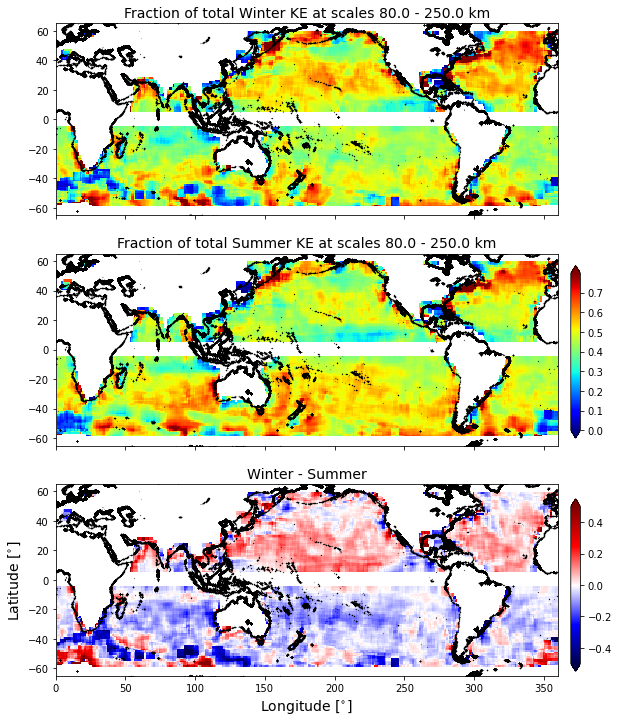

In [119]:
# seaonal changes in percent of energy in bands
land_col = '#D3D3D3'
lev2 = np.arange(0, 0.8, 0.001)
dlev1 = np.arange(1, 1001, 1)
tcmap2 = plt.get_cmap('jet')
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]
mean_mf_mask = meso_frac.copy() 
mean_mfwin_mask = smaller_frac_win.copy()
mean_mfsum_mask = smaller_frac_sum.copy()

mean_mf_mask[:, v_in] = np.nan
mean_mfwin_mask[:, v_in] = np.nan
mean_mfsum_mask[:, v_in] = np.nan

f, ax = plt.subplots(3,1,figsize=(9,12),sharex=True, sharey=True)
ax[0].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
axpmf = ax[0].pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_mfwin_mask), \
                 vmin=lev2[0], vmax=lev2[-1], zorder=0, cmap=tcmap2)
ax[0].set_title(r"Fraction of total Winter KE at scales " + \
                str(np.nanmin(coarsening_factors[meso_band_i])*hor_grid_spacing) + ' - ' + \
                str(np.nanmax(coarsening_factors[meso_band_i])*hor_grid_spacing)+ " km", fontsize=14)

ax[1].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
axpmf = ax[1].pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_mfsum_mask), \
                 vmin=lev2[0], vmax=lev2[-1], zorder=0, cmap=tcmap2)
ax[1].set_title(r"Fraction of total Summer KE at scales " + \
                str(np.nanmin(coarsening_factors[meso_band_i])*hor_grid_spacing) + ' - ' + \
                str(np.nanmax(coarsening_factors[meso_band_i])*hor_grid_spacing)+ " km", fontsize=14)
 
ax[2].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
axpmfd = ax[2].pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_mfwin_mask - mean_mfsum_mask), \
                 vmin=-0.5, vmax=0.5, zorder=0, cmap=plt.get_cmap('seismic'))
ax[2].set_title(r"Winter - Summer", fontsize=14)
ax[2].set_ylabel('Latitude [$^{\circ}$]', fontsize=14)
ax[2].set_xlabel('Longitude [$^{\circ}$]', fontsize=14)

ax[0].set_xlim([lon_w, lon_e])
ax[0].set_ylim([lat_s, lat_n])

cbpos = [0.92, 0.4, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axpmf, cax=cax, orientation='vertical', extend='both')
cbpos = [0.92, 0.13, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axpmfd, cax=cax, orientation='vertical', extend='both')
# ax[0,0].text(-40, 70, 'a)', fontweight='bold', fontsize=12)
# ax[0,1].text(-40, 70, 'b)', fontweight='bold', fontsize=12)
# ax[1,0].text(-40, 70, 'c)', fontweight='bold', fontsize=12)
# ax[1,1].text(-40, 70, 'd)', fontweight='bold', fontsize=12)
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_along_track_gridding_percent_ke.jpg', dpi=500)

In [17]:
save_p = 0
if save_p > 0:
    outputs = {'lon': lon_bin_c, 'lat': lat_bin_c, \
               'total_ke': mean_raw_mask, 'eke_120': mean_eke1_mask, 'meso_band_80_300': mean_mf_mask,}
    pickle.dump(outputs, open('/Users/jakesteinberg/Desktop/' + this_sat + '_meso_band.p', 'wb'))

In [18]:
# load al, s3a 
load_al = pickle.load(open('/Users/jakesteinberg/Desktop/al_meso_band.p', 'rb'))
load_s3a = pickle.load(open('/Users/jakesteinberg/Desktop/s3a_meso_band.p', 'rb'))

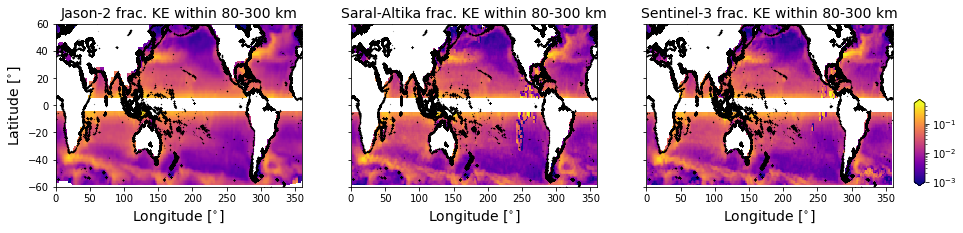

In [84]:
# plot satellite comparisons of KE in the mesoscale band
tcmap2 = plt.get_cmap('plasma')
# lev2 = np.arange(0.1, 0.7, 0.001)
lev2 = np.arange(0.001, 0.5, 0.001)
f, ax = plt.subplots(1,3,figsize=(15,3),sharey=True, sharex=True)
ax[0].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
axpmf = ax[0].pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_mf_mask*loc_tot_var_all), \
                 norm=LogNorm(vmin=lev2[0], vmax=lev2[-1]), zorder=0, cmap=tcmap2)
ax[0].set_title(r"Jason-2 frac. KE within 80-300 km", fontsize=14)
ax[0].set_xlabel('Longitude [$^{\circ}$]', fontsize=14)
ax[0].set_ylabel('Latitude [$^{\circ}$]', fontsize=14)

ax[1].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
axpmf = ax[1].pcolor(lon_bin_c, lat_bin_c, np.transpose(load_al['meso_band_80_300']*load_al['total_ke'][1:][:,1:]), \
                 norm=LogNorm(vmin=lev2[0], vmax=lev2[-1]), zorder=0, cmap=tcmap2)
ax[1].set_title(r"Saral-Altika frac. KE within 80-300 km", fontsize=14)
ax[1].set_xlabel('Longitude [$^{\circ}$]', fontsize=14)

ax[2].scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.01)   
axpmf = ax[2].pcolor(lon_bin_c, lat_bin_c, np.transpose(load_s3a['meso_band_80_300']*load_s3a['total_ke'][1:][:,1:]), \
                 norm=LogNorm(vmin=lev2[0], vmax=lev2[-1]), zorder=0, cmap=tcmap2)
ax[2].set_title(r"Sentinel-3 frac. KE within 80-300 km", fontsize=14)
ax[2].set_xlabel('Longitude [$^{\circ}$]', fontsize=14)
ax[0].set_xlim([lon_w, lon_e])
ax[0].set_ylim([lat_s, lat_n])
cbpos = [0.92, 0.13, 0.01, 0.4]
cax = f.add_axes(cbpos)
cb = f.colorbar(axpmf, cax=cax, orientation='vertical', extend='both')
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/three_sat_comparison_nonfrac.jpg', dpi=500)

In [156]:
# SPECTRAL ANALOGUE at 5 locations 
loc_points = np.concatenate((np.array([np.nanmean(location[0, 2:]), np.nanmean(location[0, 0:2])])[None, :], \
                             np.array([np.nanmean(location[1, 2:]), np.nanmean(location[1, 0:2])])[None, :], \
                             np.array([np.nanmean(location[2, 2:]), np.nanmean(location[2, 0:2])])[None, :], \
                             np.array([np.nanmean(location[3, 2:]), np.nanmean(location[3, 0:2])])[None, :], \
                             np.array([np.nanmean(location[4, 2:]), np.nanmean(location[4, 0:2])])[None, :], \
                             np.array([np.nanmean(location[5, 2:]), np.nanmean(location[5, 0:2])])[None, :]), axis=0)
labely = order
# --------
# labely_s = ['Eastern N. Pac. [JAS]', 'Gulf Stream [JAS]', 'Kuroshio [JAS]', \
#           'Indian [FMA]', 'ACC [JAS]', 'N. Atl. [JAS]']
loc_points = loc_points
labely = labely
# labely_s = labely_s

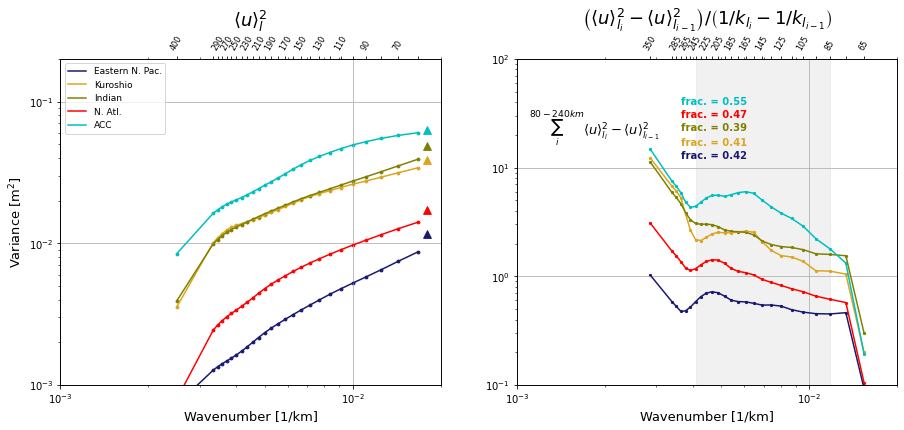

In [160]:
# loc_points = [[38.75, 298.75], [1.25, 251.25], [21.25, 151.25], [-41.25, 18.75], [-56.25, 81.25]]
# colors = ['cornflowerblue', 'orangered', 'olivedrab', 'goldenrod', 'k']  # 'darkmagenta']
colors = ['#191970', '#DAA520', '#808000', 'r', 'c', 'm']
loc_var = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_G = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_B = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_spread = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_eke = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_sum_spread = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_win_sq = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_sum_sq = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_large_sc_var = np.nan * np.ones((len(loc_points)))
loc_tot_var = np.nan * np.ones((len(loc_points)))
for i in range(len(loc_points[0:5])):
    # within each box, find eke or other quantity (only take one value from the map...dont average again)
    ll = np.where((lat_bin_c > (location[i][2] + 1.25)) & (lat_bin_c < (location[i][3] - 1.25)))[0][0]
    kk = np.where((lon_bin_c > (location[i][0] + 1.25)) & (lon_bin_c < (location[i][1] - 1.25)))[0][0]
    
    # ** still large to small ... optionally average over a certain time of the year ** 
    # average only in time 
    loc_var[i, :] = np.nanmean(mean_sla_smooth[:][:, kk, ll, :], axis=0)  # tuple(range(0, 3))
    loc_var_G[i, :] = np.nanmean(mean_sla_smoothG[:][:, kk, ll, :], axis=0)
    # loc_var_B[i, :] = np.nanmean(mean_sla_smoothB[:][:, kk, ll, :], axis=0)
    loc_var_eke[i, :] = np.nanmean(mean_diff0[:][:, kk, ll, :], axis=0)   # tuple(range(0, 3))

    # loc_var_spread[i, :] = [np.nanstd(mean_diff0_3[:][:, kk, :][:, :, ll]), \
    #                             np.nanstd(mean_diff0_13[:][:, kk, :][:, :, ll])]  
    
    # loc_large_sc_var[i] = np.nanmean(mean_diff0_13[:, kk, :][:, :, ll])
    loc_tot_var[i] = np.nanmean(mean_sla0[:][:, kk, ll])  # np.nanmean(mean_sla_total[kk][:, ll])
    
# loc_var = np.fliplr(loc_var)
# loc_var_spread = np.fliplr(loc_var_spread)
# loc_var_eke = np.fliplr(loc_var_eke)

# PLOT 
f, (ax3, ax) = plt.subplots(1, 2, figsize=(15,6))
ax2 = ax.twiny()
ax4 = ax3.twiny()
mi = np.where((band_centers > 80) & (band_centers < 250))[0]
ax.fill_between(1/np.array(band_centers[mi]), 100*np.ones(len(band_centers[mi])), color='#DCDCDC', alpha=0.4)  # sample_band[2:8]
y_pos = np.array([1.2, 1.6, 2.2, 2.9, 3.8])*10**(1)
for i in range(len(loc_points[0:5])):  # len(loc_points[0:5])
    ax3.scatter([1.8*10**(-2)], loc_tot_var[i], color=colors[i], s=60, marker="^")
    # ax.scatter([1.5*10**(-3) + i*2*10**(-8)], loc_large_sc_var[i], color=colors[i], s=60, marker="*")  
    
    # -- all
    # ax3.plot(1/np.array(band_centers[0:-1]), (loc_var[i, 0:-1]), label=labely[i], color=colors[i])
    # ax3.scatter(1/np.array(band_centers[0:-1]), (loc_var[i, 0:-1]), color=colors[i])
    
    ax3.plot(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var[i, :]), label=labely[i], color=colors[i])
    # ax3.plot(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var_G[i, :]), label=labely[i] + ', Gaussian', color=colors[i], linestyle='--')
    # ax3.plot(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var_B[i, :]), label=labely[i] + ', boxcar', color=colors[i], linestyle='-.')
    ax3.scatter(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var[i, :]), color=colors[i], s=8)
    # ax3.plot(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var_eke[i, :]), label=labely[i], color=colors[i])
    
    # -- difference (between bands)
    # ax.bar(1/np.array(band_centers[0:-1]), \
    #        (loc_var[i, 1:] - loc_var[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
    #        color=colors[i], width=(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
    #        log=True, align="center", alpha=0.5)

    # ax.plot(1/np.array(band_centers[0:-1]), (loc_var[i, 1:] - loc_var[i, 0:-1]), label=labely[i], color=colors[i])
    ax.plot(1/np.array(band_centers[0:-1]), (loc_var[i, 1:] - loc_var[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), label=labely[i], color=colors[i])
    ax.scatter(1/np.array(band_centers[0:-1]), \
               (loc_var[i, 1:] - loc_var[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
               color=colors[i], s=5)
    # ax.scatter(1/60, loc_var_eke[i, 0]/(1/10 - 1/60), color=colors[i]) # eke at scales less than 80 
    # ax.plot(1/np.array(band_centers[0:-1]), (loc_var_G[i, 1:] - loc_var_G[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
    #         label=labely[i], color=colors[i], linestyle='--')
       
    # -- eke (old=summer)
    # ax3.plot(1/np.array(band_centers[0:np.shape(loc_var_sum)[1]]), loc_var_eke[i, :], color=colors[i], linestyle='--')
    # ax.scatter(1/(np.array(band_centers[0:np.shape(loc_var_sum)[1]]) - band_centers[0:np.shape(loc_var_sum)[1]]*.005), \
    #            loc_var_sum[i, :], color=colors[i], s=5)
    # for j in range(len(loc_var_sum[i, :])):
    #     ax.plot(1/(np.array(band_centers[j]) - band_centers[j]*.005) * np.ones(2), \
    #             [loc_var_sum[i, j] - loc_var_sum_spread[i, j], loc_var_sum[i, j] + loc_var_sum_spread[i, j]], \
    #             color=colors[i])    

    sample_band = (loc_var[i, 1:] - loc_var[i, 0:-1])
    ax.text(1/np.array(band_centers[3]), y_pos[i], \
            'frac. = ' + str(np.round(np.sum(sample_band[mi])/loc_tot_var[i], 2)), color=colors[i], fontweight='bold')
    
ax.text(1.1*10**(-3), 2*10**(1), \
        r'$\sum_{i}^{80-240km} \langle u \rangle_{l_i}^2 - \langle u \rangle_{l_{i-1}}^2$', fontsize=13)
    
ax.grid()
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1*10**(-3), 2*10**(-2)])
# ax3.set_ylim([1*10**(-1), 3*10**(0)])
ax3.set_ylim([1*10**(-3), 2*10**(-1)])
# ax3.set_ylim([2*10**(-3), 4*10**(-2)])
ax3.set_xlabel('Wavenumber [1/km]', fontsize=13)
ax3.set_ylabel(r'Variance [m$^2$]', fontsize=13)
ax3.set_title(r"$\langle u \rangle _l^2$", fontsize=18)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1*10**(-3), 2*10**(-2)])
ax.set_ylim([1*10**(-1), 1*10**(2)])
# ax.set_ylim([1*10**(-3), 3*10**(1)])
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(1/np.array(band_centers[0:-1]))
bcl = []
for i in range(len(band_centers[0:-1])):
    if np.mod(i, 2):
        bcl.append('')
    else:
        bcl.append(str(np.round(np.int(band_centers[i]))))
ax2.set_xticklabels(bcl, rotation=60, fontsize=8)
ax.set_xlabel('Wavenumber [1/km]', fontsize=13)
# ax.set_ylabel(r'Variance [m$^2$]', fontsize=13)
# ax.set_title(r"$\left( \langle u \rangle_{l_{i}}^2 - \langle u \rangle_{l_{i-1}}^2 \right)$", fontsize=18)
ax.set_title(r"$\left( \langle u \rangle_{l_{i}}^2 - \langle u \rangle_{l_{i-1}}^2 \right) / \left( 1/k_{l_i} - 1/k_{l_{i-1}} \right)$", fontsize=18)

ax4.set_xscale('log')
# ax4.set_xticks(1/np.array(band_centers[0:-1]))
ax4.set_xticks(1/np.array(coarsening_factors*hor_grid_spacing))
bcl = []
for i in range(len(coarsening_factors)):
    if np.mod(i, 2):
        bcl.append('')
    else:
        # bcl.append(str(np.round(np.int(band_centers[i]))))
        bcl.append(str(np.round(np.int(coarsening_factors[i]*hor_grid_spacing))))
ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(1/np.array(coarsening_factors*hor_grid_spacing))
ax4.set_xticklabels(bcl, rotation=60, fontsize=8)

ax3.grid()
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_per_scale_banded_sharp_vs_g.jpg', dpi=400)

In [300]:
sample_band = (loc_var[2, 1:] - loc_var[2, 0:-1])
print('sum of filtered variances = ' + str(np.sum(sample_band)))
print('variance between 240km and 80km = ' + str(np.sum(sample_band[2:9])))
print('total unfiltered variance = ' + str(loc_tot_var[2]))
print(coarsening_factors*10)
# print(band_ends)
print(band_centers)

sum of filtered variances = 0.02403643955095478
variance between 240km and 80km = 0.01883248032055981
total unfiltered variance = 0.03690507656987421
[380. 300. 240. 200. 180. 160. 140. 120. 100.  80.  60.]
[340. 270. 220. 190. 170. 150. 130. 110.  90.  70.  35.]


In [36]:
band_ends = np.flip(band_ends)
band_ends

array([ 60.,  80., 100., 120., 140., 160., 180., 200., 240., 300., 380.])

In [37]:
# AVISO CHECK 
aviso10 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2010_jan_may.nc')
aviso11 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2010_aug_nov.nc')
aviso20 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2011_jan_may.nc')
aviso21 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2011_aug_nov.nc')
aviso30 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2012_jan_may.nc')
aviso31 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2012_aug_nov.nc')
aviso40 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2013_jan_may.nc')
aviso41 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2013_aug_nov.nc')
aviso50 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2014_jan_may.nc')
aviso51 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2014_aug_nov.nc')
aviso_lon = aviso10['longitude'].data
aviso_lat = aviso10['latitude'].data

In [38]:
aviso_time = aviso10.time.data
a_u = np.concatenate((aviso10.ugos.data, aviso20.ugos.data, aviso30.ugos.data, aviso40.ugos.data, aviso50.ugos.data), axis=0)
a_v = np.concatenate((aviso10.vgos.data, aviso20.vgos.data, aviso30.vgos.data, aviso40.vgos.data, aviso50.vgos.data), axis=0)

In [39]:
a_k = 0.5 * (np.nanmean(a_u**2, axis=0) + np.nanmean(a_v**2, axis=0))

In [40]:
# AVISO by season
a_win_in = np.arange(31,120)  # feb-apr
a_sum_in = np.arange(0,92)  # aug-oct
a_u_march = np.concatenate((aviso10.ugos.data[a_win_in], \
                            aviso20.ugos.data[a_win_in], aviso30.ugos.data[a_win_in], \
                            aviso40.ugos.data[a_win_in], aviso50.ugos.data[a_win_in]), axis=0)
a_v_march = np.concatenate((aviso10.vgos.data[a_win_in], \
                            aviso20.vgos.data[a_win_in], aviso30.vgos.data[a_win_in], \
                            aviso40.vgos.data[a_win_in], aviso50.vgos.data[a_win_in]), axis=0)

a_u_sept = np.concatenate((aviso11.ugos.data[a_sum_in], \
                           aviso21.ugos.data[a_sum_in], aviso31.ugos.data[a_sum_in], \
                           aviso41.ugos.data[a_sum_in], aviso51.ugos.data[a_sum_in]), axis=0)
a_v_sept = np.concatenate((aviso11.vgos.data[a_sum_in], \
                           aviso21.vgos.data[a_sum_in], aviso31.ugos.data[a_sum_in], \
                           aviso41.vgos.data[a_sum_in], aviso51.ugos.data[a_sum_in]), axis=0)
march_ke = 0.5 * (np.nanmean(a_u_march**2, axis=0) + np.nanmean(a_v_march**2, axis=0))
sept_ke = 0.5 * (np.nanmean(a_u_sept**2, axis=0) + np.nanmean(a_v_sept**2, axis=0))

In [41]:
# smooth aviso 
a_ke = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
a_ke_win = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
a_ke_sum = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]
        
        this_lon0 = this_lon - lon_win/2
        this_lon1 = this_lon + lon_win/2
        this_lat0 = this_lat - lat_win/2
        this_lat1 = this_lat + lat_win/2
        
        alon_in = np.where((aviso_lon >= this_lon0) & (aviso_lon <= this_lon1))[0]
        alat_in = np.where((aviso_lat >= this_lat0) & (aviso_lat <= this_lat1))[0]
        a_ke_win[i, j] = np.nanmean(march_ke[alat_in, :][:, alon_in]) 
        a_ke_sum[i, j] = np.nanmean(sept_ke[alat_in, :][:, alon_in]) 
        a_ke[i, j] = np.nanmean(a_k[alat_in, :][:, alon_in])

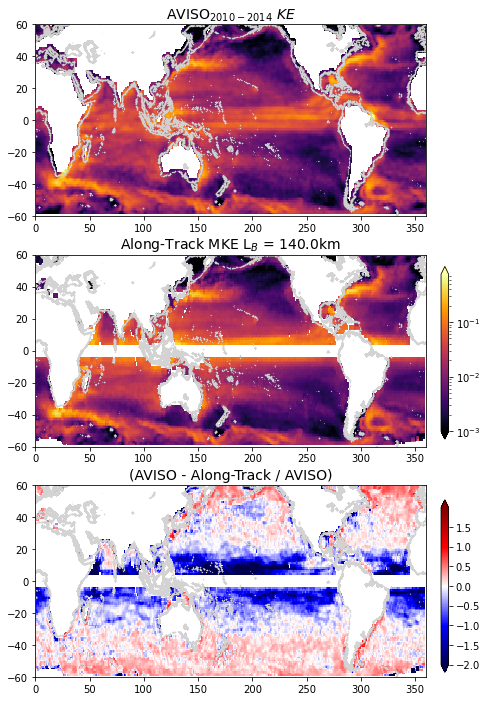

In [64]:
# what smoothing of at data is needed to reproduce aviso 
tcmap = plt.get_cmap('inferno')
tcmap2 = plt.get_cmap('seismic')
land_col = '#D3D3D3'
lev1 = np.arange(0.001, 0.75, 0.001)
lev2 = np.arange(-2, 2, 0.001)
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]
mean_mke_mask = np.nanmean(mean_sla_smooth7, axis=0) 

f, (ax1,ax2,ax3) = plt.subplots(3,1,sharey=True, figsize=(7,12))
ax1.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(a_ke), norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), \
                 cmap=tcmap, zorder=0)
ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_mke_mask), \
                 norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), zorder=0, cmap=tcmap)
ax3.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp2 = ax3.pcolor(lon_bins, lat_bins, np.transpose((a_ke - mean_mke_mask)/a_ke), \
                 vmin=lev2[0], vmax=lev2[-1], zorder=0, cmap=tcmap2)
# vmin=diff_lev1[0], vmax=diff_lev1[-1]
ax1.set_title(r"AVISO$_{2010-2014}$ $KE$", fontsize=14)
ax2.set_title(r"Along-Track MKE L$_B$ = " + str(band_ends[4]) + "km", fontsize=14)
ax3.set_title(r"(AVISO - Along-Track / AVISO)", fontsize=14)
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])

cbpos = [0.93, 0.4, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')
cbpos = [0.93, 0.13, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp2, cax=cax, orientation='vertical', extend='both')
plt.show()

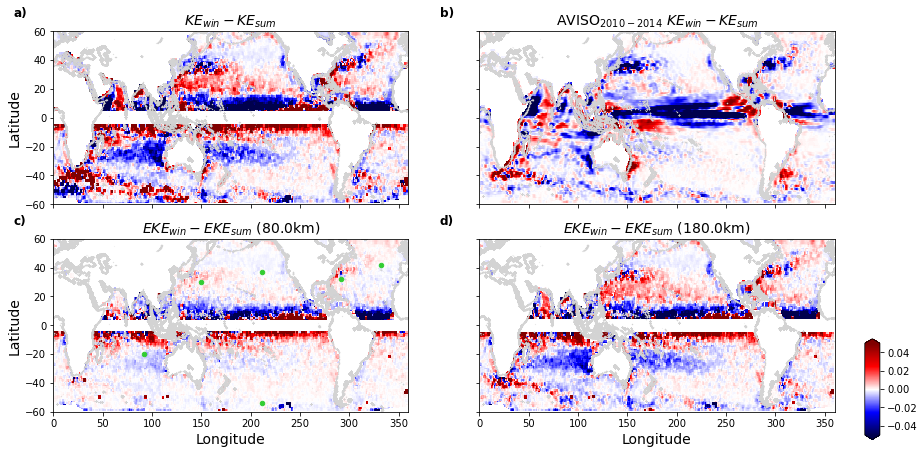

In [356]:
# EKE summer vs. winter
# diff_lev = np.arange(0.00001, 0.01, 0.00001)
# diff_lev1 = np.arange(0.01, 10, 0.0001)
diff_lev1 = np.arange(-.05, 0.05, 0.0001)
# diff_lev1 = np.arange(-10, 10, 0.0001)
# tcmap = cmocean.cm.thermal
tcmap = plt.get_cmap('seismic')
land_col = '#D3D3D3'

# plot, excluding equator 
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]
mean_raw_mask = np.nanmean(mean_sla0[win_in],axis=0) - np.nanmean(mean_sla0[sum_in], axis=0)   # (mean_diff0_7 - mean_diff1_7).copy()
mean_v4_mask = np.nanmean(mean_diff0_4[win_in],axis=0) - np.nanmean(mean_diff0_4[sum_in], axis=0)   # (mean_diff0_7 - mean_diff1_7).copy()
mean_v7_mask = np.nanmean(mean_diff0_7[win_in],axis=0) - np.nanmean(mean_diff0_7[sum_in], axis=0)   # (mean_diff0_7 - mean_diff1_7).copy()
mean_v8_mask = np.nanmean(mean_diff0_8[win_in],axis=0) - np.nanmean(mean_diff0_8[sum_in], axis=0)   # (mean_diff0_8 - mean_diff1_8).copy()
mean_v9_mask = np.nanmean(mean_diff0_9[win_in],axis=0) - np.nanmean(mean_diff0_9[sum_in], axis=0)   # (mean_diff0_9 - mean_diff1_9).copy()
mean_v10_mask = np.nanmean(mean_diff0_10[win_in],axis=0) - np.nanmean(mean_diff0_10[sum_in], axis=0)  # (mean_diff0_10 - mean_diff1_10).copy()
mean_v11_mask = np.nanmean(mean_diff0_11[win_in],axis=0) - np.nanmean(mean_diff0_11[sum_in], axis=0)  # (mean_diff0_11 - mean_diff1_11).copy()
mean_v12_mask = np.nanmean(mean_diff0_12[win_in],axis=0) - np.nanmean(mean_diff0_12[sum_in], axis=0)  # (mean_diff0_12 - mean_diff1_12).copy()
mean_v13_mask = np.nanmean(mean_diff0_13[win_in],axis=0) - np.nanmean(mean_diff0_13[sum_in], axis=0)  # (mean_diff0_13 - mean_diff1_13).copy()
# mean_v7_mask = (mean_diff0_7/mean_sla_smooth7 - mean_diff1_7/mean_sla_smooth7_sum).copy()
# mean_v8_mask = (mean_diff0_8/mean_sla_smooth8 - mean_diff1_8/mean_sla_smooth8_sum).copy()
# mean_v9_mask = (mean_diff0_9/mean_sla_smooth9 - mean_diff1_9/mean_sla_smooth9_sum).copy()
# mean_v10_mask = (mean_diff0_10/mean_sla_smooth10 - mean_diff1_10/mean_sla_smooth10_sum).copy()
# mean_v11_mask = (mean_diff0_11/mean_sla_smooth11 - mean_diff1_11/mean_sla_smooth11_sum).copy()
# mean_v12_mask = (mean_diff0_12/mean_sla_smooth12 - mean_diff1_12/mean_sla_smooth12_sum).copy()
# mean_v13_mask = (mean_diff0_13/mean_sla_smooth13 - mean_diff1_13/mean_sla_smooth13_sum).copy()
mean_raw_mask[:, v_in] = np.nan
mean_v7_mask[:, v_in] = np.nan
mean_v8_mask[:, v_in] = np.nan
mean_v9_mask[:, v_in] = np.nan
mean_v10_mask[:, v_in] = np.nan
mean_v11_mask[:, v_in] = np.nan
mean_v12_mask[:, v_in] = np.nan
mean_v13_mask[:, v_in] = np.nan

f, ((ax3, ax4), (ax1, ax2)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14, 7))

ax1.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_v4_mask), \
                 vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla), levels=diff_lev, cmap=tcmap, linewidths=0.5)
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_title(r"$EKE_{win} - EKE_{sum}$ (" + str(band_ends[1]) + "km)", fontsize=14)  
for i in range(np.shape(loc_points)[0]):
    ax1.scatter(loc_points[i, 1], loc_points[i, 0], s=20, color='#32CD32', zorder=2)
ax1.set_ylabel('Latitude', fontsize=14)

# ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v8_mask), \
#                  vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
# ax2.set_title(r"$(\tau(u, u))_{win} - (\tau(u, u))_{sum}$ (" + str(band_ends[1]) + "km)")
# for i in range(np.shape(loc_points)[0]):
#     ax1.scatter(loc_points[i, 1], loc_points[i, 0], s=20, color='#32CD32', zorder=2)

# ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v9_mask), \
#                  vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
# ax2.set_title(r"$(\tau(u, u))_{win} - (\tau(u, u))_{sum}$ (" + str(band_ends[2]) + "km)")

# ax4.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax4.pcolor(lon_bins, lat_bins, np.transpose(mean_v10_mask), \
#                  vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
# ax4.set_title(r"$(\tau(u, u))_{win} - (\tau(u, u))_{sum}$ (" + str(band_ends[3]) + "km)")
# ax4.set_ylabel('Latitude')

ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v9_mask), \
                 vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
ax2.set_title(r"$EKE_{win} - EKE_{sum}$ (" + str(band_ends[6]) + "km)", fontsize=14)

# ax6.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax6.pcolor(lon_bins, lat_bins, np.transpose(mean_v12_mask), \
#                  vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
# ax6.set_title(r"$(\tau(u, u))_{win} - (\tau(u, u))_{sum}$ (" + str(band_ends[5]) + "km)")

# ax4.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax4.pcolor(lon_bins, lat_bins, np.transpose(mean_v13_mask), \
#                  vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
# ax4.set_title(r"$(\tau(u, u))_{win} - (\tau(u, u))_{sum}$ (" + str(band_ends[6]) + "km)")
# ax4.set_xlabel('Longitude')
# ax4.set_ylabel('Latitude')

ax3.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_raw_mask), \
                 vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
ax3.set_title(r"$KE_{win} - KE_{sum}$", fontsize=14)
ax1.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)

ax4.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax4.pcolor(lon_bin_c, lat_bin_c, np.transpose(a_ke_win - a_ke_sum), vmin=diff_lev1[0], vmax=diff_lev1[-1], cmap=tcmap, zorder=0)
ax4.set_title(r"AVISO$_{2010-2014}$ $KE_{win} - KE_{sum}$", fontsize=14)
ax2.set_xlabel('Longitude', fontsize=14)

cbpos = [0.93, 0.07, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

ax1.text(-40, 70, 'c)', fontweight='bold', fontsize=12)
ax3.text(-40, 70, 'a)', fontweight='bold', fontsize=12)
ax2.text(-40, 70, 'd)', fontweight='bold', fontsize=12)
ax4.text(-40, 70, 'b)', fontweight='bold', fontsize=12)

plt.show()
# f.savefig(this_sat + '_sla_scales.jpg', dpi=400)
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_winter_summer_w_aviso.jpg', dpi=400)

In [378]:
np.shape(time_record[gid])
from datetime import datetime
str(datetime.utcfromtimestamp(time_record[gid][90]))[0:10]

'2011-03-31'

In [390]:
print(len(aviso20.time.data))
aviso20.time.data[89]  # .ugos.data

151


numpy.datetime64('2011-03-31T00:00:00.000000000')

In [411]:
from scipy.interpolate import griddata
np.shape(aviso20.ugos.data[89])
test_u = aviso20.ugos.data[89]
test_v = aviso20.vgos.data[89]
aviso_lon_grid, aviso_lat_grid = np.meshgrid(aviso_lon, aviso_lat)
points = np.concatenate( (aviso_lon_grid.flatten()[:, None], aviso_lat_grid.flatten()[:, None]), axis=1)
values_u = test_u.flatten()
values_v = test_v.flatten()
lon_sel = lon_record[gid]
lat_sel = lat_record[gid]
X0 = lon_sel
Y0 = lat_sel
aviso_at_u = griddata(points, values_u, (X0, Y0))
aviso_at_v = griddata(points, values_v, (X0, Y0))

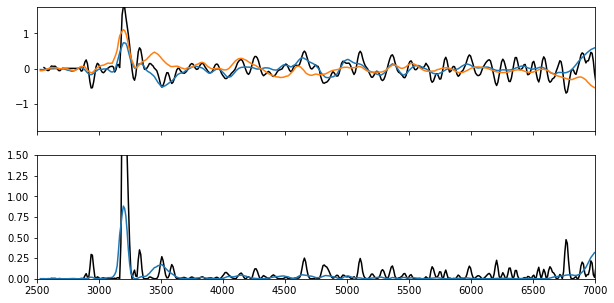

In [419]:
# extract AVISO along single track of j2 
# track = 24
# pass = 10
t_i = np.array([24.0])
gid = np.where(track_record == t_i)[0][0]
pass_index = 5

lon_sel = lon_record[gid]
lat_sel = lat_record[gid]
dist_sel = dist[gid]

f, (ax, ax2)= plt.subplots(2, 1, sharex=True, figsize=(10, 5))
ax.plot(dist_sel, vel[gid][90, :], color='k')
ax.plot(dist_sel, aviso_at_u)
ax.plot(dist_sel, aviso_at_v)

ax2.plot(dist_sel, vel[gid][90, :]**2, color='k')
ax2.plot(dist_sel, 0.5*(aviso_at_u**2 + aviso_at_v**2))

ax.set_ylim([-1.75, 1.75])
ax.set_xlim([2500, 7000])
ax2.set_ylim([0, 1.5])
plt.show()

In [422]:
import pickle
outputs = {'aviso_u_at': aviso_at_u, 'aviso_v_at': aviso_at_v, \
           'at_dist': dist_sel, 'at_lon': lon_sel, 'at_lat': lat_sel}
pickle.dump(outputs, open('/Users/jakesteinberg/Desktop/' + this_sat + \
                          '_aviso_interp_to_track_24_31mar2011.p', 'wb'))

In [129]:
c98 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/global_deformation_radius_chelton_1998.nc') 
c98_1 = c98['values'].data
def_rad = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
rhines = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
for i in range(len(lat_bin_c)):
    for j in range(len(lon_bin_c)):
        c_in = np.where((c98_1[:, 0] > (lat_bin_c[i] - 2)) & (c98_1[:, 0] < (lat_bin_c[i] + 2)) & \
                 (c98_1[:, 1] > (lon_bin_c[j] - 2)) & (c98_1[:, 1] < (lon_bin_c[j] + 2)))[0]
        if len(c_in) > 1:
            def_rad[i, j] = np.nanmean(c98_1[c_in, 3])
        beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_bin_c[i]))/(6356752)
        rhines[i, j] = np.sqrt(np.sqrt(mean_sla_total[j,i])/beta)

In [124]:
coarsening_factors

array([40., 30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19.,
       18., 17., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.])

In [126]:
np.shape(mean_diff0)
# np.nanmean(mean_diff0[:][:, kk, ll, :], axis=0) # dimensions = [time, lon, lat, cf]

(12, 360, 120, 26)

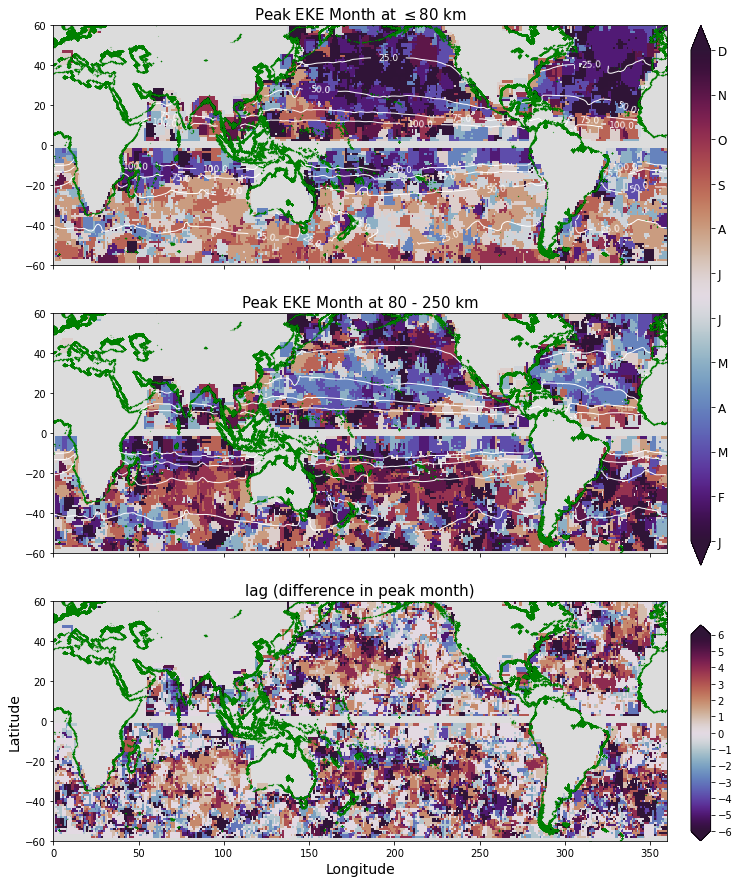

In [135]:
# scales to map
scale1 = np.where(coarsening_factors == 8)[0]
scale2 = np.where(coarsening_factors == 25)[0]
pct_diff_cutoff = 0.25
# find month that has most eke at each scale 
max_month_1 = np.nan * np.ones(np.shape(mean_diff0[0, :, :, 0]))
max_month_2 = np.nan * np.ones(np.shape(mean_diff0[0, :, :, 0]))
for i in range(np.shape(mean_diff0)[1]):
    for j in range(np.shape(mean_diff0)[2]):
        # -- scale1 (smaller)
        if (~np.isnan(np.nanmax(mean_diff0[:, i, j, scale1]))) & \
        (np.abs(np.nanmax(mean_diff0[:, i, j, scale1]) - np.nanmin(mean_diff0[:, i, j, scale1]))/np.nanmean(mean_diff0[:, i, j, scale1]) > pct_diff_cutoff):
            this_ij = np.where(mean_diff0[:, i, j, scale1] == np.nanmax(mean_diff0[:, i, j, scale1]))[0]
            if len(this_ij) > 1:
                max_month_1[i, j] = np.nanmean(this_ij) + 1
            else:
                max_month_1[i, j] = this_ij + 1
        # -- scale2 (larger) 
        if (~np.isnan(np.nanmax(mean_diff0[:, i, j, scale2]))) & \
        (np.abs(np.nanmax(mean_diff0[:, i, j, scale2]) - np.nanmin(mean_diff0[:, i, j, scale2]))/np.nanmean(mean_diff0[:, i, j, scale2]) > pct_diff_cutoff):
            test = mean_diff0[:, i, j, scale2] - mean_diff0[:, i, j, scale1]  # difference between scales 
            this_ij = np.where(test == np.nanmax(test))[0]
            # this_ij = np.where(mean_diff0_11[:, i, j] == np.nanmax(mean_diff0_11[:, i, j]))[0]
            if len(this_ij) > 1:
                max_month_2[i, j] = np.nanmean(this_ij) + 1
            else:
                max_month_2[i, j] = this_ij + 1

# -- try smoothing to make picture prettier 
max_month_1_smoothed = np.nan * np.ones(np.shape(mean_diff0[0, :, :, 0]))
max_month_2_smoothed = np.nan * np.ones(np.shape(mean_diff0[0, :, :, 0]))
for i in range(2, np.shape(max_month_1)[0] - 2):
    for j in range(2, np.shape(max_month_1)[1] -2):
        max_month_1_smoothed[i,j] = np.nanmean(max_month_1[i-1:i+2, j-1:j+2])
        max_month_2_smoothed[i,j] = np.nanmean(max_month_2[i-1:i+2, j-1:j+2])

# PLOT         
land_col = '#DCDCDC'
f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(11,15),sharex=True,sharey=True)
ax1.set_facecolor(land_col)
ax2.set_facecolor(land_col)
ax3.set_facecolor(land_col)
ax1.scatter(x4['lon'].values, x4['lat'].values, color='g', zorder=1, s=0.01)
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(max_month_1), \
                 vmin=1, vmax=12, zorder=0, cmap=plt.get_cmap('twilight_shifted'))  # plt.get_cmap('twilight')# cmocean.cm.phase)
dr = ax1.contour(lon_bin_c, lat_bin_c, def_rad, \
                 levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2)
ax1.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')

ax2.scatter(x4['lon'].values, x4['lat'].values, color='g', zorder=1, s=0.01)
axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(max_month_2), \
                 vmin=1, vmax=12, zorder=0, cmap=plt.get_cmap('twilight_shifted'))
ax2.contour(lon_bin_c, lat_bin_c, def_rad, \
                 levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2)

# check that 
mo_lag = max_month_2 - max_month_1
for i in range(np.shape(max_month_2)[0]):
    pos_lag_easy = np.where(max_month_2[i, :] > max_month_1[i, :])[0]
    # pos_lag_hard = np.where( (max_month_2[i, :] < max_month_1[i, :]) & \
    #                         (max_month_2[i, :] < 9) & (max_month_1[i, :] >= 9) )[0]
    lag_hard1 = np.where( (max_month_1[i, :] >= 9.0) & (max_month_2[i, :] < 6.0) )[0]
    lag_hard2 = np.where( (max_month_2[i, :] >= 9.0) & (max_month_1[i, :] < 6.0) )[0]
    mo_lag[i, lag_hard1] = mo_lag[i, lag_hard1] + 12
    mo_lag[i, lag_hard2] = mo_lag[i, lag_hard2] - 12

ax3.scatter(x4['lon'].values, x4['lat'].values, color='g', zorder=1, s=0.01)
axp2 = ax3.pcolor(lon_bin_c, lat_bin_c, np.transpose(mo_lag), \
                 vmin=-6, vmax=6, zorder=0, cmap=plt.get_cmap('twilight_shifted')) # 'PiYG'
ax3.set_title('lag (difference in peak month)', fontsize=15)
ax3.set_xlabel('Longitude',fontsize=14)
ax3.set_ylabel('Latitude',fontsize=14)

# dr = ax3.contour(lon_bin_c, lat_bin_c, def_rad/(rhines/1000), levels=[0.4, 0.6], colors='w', linewidths=3.5, zorder=2)
# ax3.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')

cbpos = [0.93, 0.38, 0.025, 0.5]
cbpos2 = [0.93, 0.125, 0.025, 0.2]
cax = f.add_axes(cbpos)
cax2 = f.add_axes(cbpos2)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', ticks=np.arange(1,13))
cb.ax.set_yticklabels([month_labels[0],month_labels[1],month_labels[2],\
                       month_labels[3],month_labels[4],month_labels[5],\
                       month_labels[6],month_labels[7],month_labels[8], 
                       month_labels[9],month_labels[10],month_labels[11]], fontsize=12)
cb2 = f.colorbar(axp2, cax=cax2, orientation='vertical', extend='both', ticks=np.arange(-6,7))
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s + 5, lat_n - 5])
ax1.set_title('Peak EKE Month at $\leq$' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' km', fontsize=15)
ax2.set_title('Peak EKE Month at ' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' - ' + \
              str(np.int(coarsening_factors[scale2][0]*hor_grid_spacing)) + ' km', fontsize=15)
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_max_eke_month_diff_25pct_criteria.jpg', dpi=500)

In [140]:
# length scale at which normalized bands are maxima    
mi = np.where((band_centers > 80) & (band_centers < 250))[0]
mi_band = band_centers[mi]

# find scale that has most eke at each location 
loc_var_a = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c), len(band_centers)))
band_var_a = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c), len(band_centers)-1))
max_scale = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in range(len(lon_bin_c)):
    for j in range(len(lat_bin_c)):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]        
        this_lon0 = this_lon - 0.5  # lon_win/2
        this_lon1 = this_lon + 0.5  # lon_win/2
        this_lat0 = this_lat - 0.5  # lat_win/2
        this_lat1 = this_lat + 0.5  # lat_win/2       
        ll = np.where((lat_bin_c > (this_lat0 - 0.25)) & (lat_bin_c < (this_lat1 + 0.25)))[0]
        kk = np.where((lon_bin_c > (this_lon0 - 0.25)) & (lon_bin_c < (this_lon1 + 0.25)))[0]
        
        # mke for all filter scales at all locations (flip so we go from large scale to small scale)
        loc_var_a[i, j, :] = np.nanmean(mean_sla_smooth[:][:, kk, ll, :], axis=0)
            # [np.nanmean(mean_sla_smooth0[:][:, kk, :][:, :, ll]), np.nanmean(mean_sla_smooth26[:][:, kk, :][:, :, ll])]  # mean_diff0_3
        band_var_a[i, j, :] = (loc_var_a[i, j, 1:] - loc_var_a[i, j, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1]))


        # -- max scale
        
        this_ij = np.where(band_var_a[i, j, mi] == np.nanmax(band_var_a[i, j, mi]))[0]
        if (len(this_ij) >= 1) & (len(this_ij) <= 3):
            max_scale[i, j] = mi_band[this_ij]
            # if len(this_ij) > 1:
            #     max_scale[i, j] = np.nanmean(this_ij) + 1
            # else:
            #     max_month_1[i, j] = this_ij + 1
                

In [138]:
np.nanmin(max_scale)

85.0

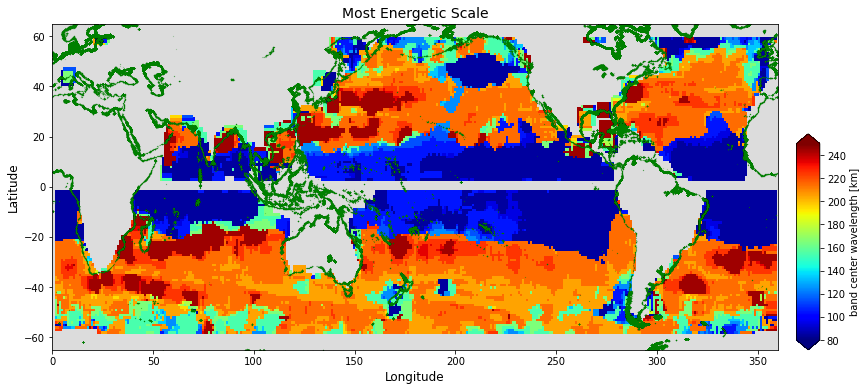

In [145]:
f, ax1 = plt.subplots(1,1,figsize=(13,6))
ax1.set_facecolor('#DCDCDC')
ax1.scatter(x4['lon'].values, x4['lat'].values, color='g', zorder=1, s=0.01)
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(max_scale), \
                 vmin=80, vmax=250, zorder=0, cmap=plt.get_cmap('jet'))  # plt.get_cmap('twilight')# cmocean.cm.phase)
# dr = ax1.contour(lon_bin_c, lat_bin_c, def_rad, levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2)
# ax1.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')
cbpos2 = [0.92, 0.125, 0.025, 0.5]
cax2 = f.add_axes(cbpos2)
cb2 = f.colorbar(axp, cax=cax2, orientation='vertical', extend='both', label='band center wavelength [km]')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title('Most Energetic Scale', fontsize=14)
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_most_energetic.jpg', dpi=500)

In [122]:
np.nanmin(max_scale)

90.0

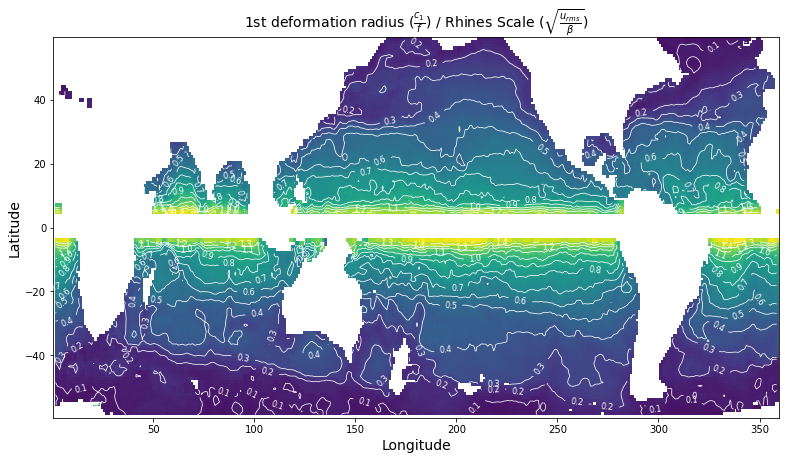

In [175]:
f, ax = plt.subplots(1,1,figsize=(13,7))
ax.pcolor(lon_bin_c, lat_bin_c, def_rad/(rhines/1000), vmin=0, vmax=1.5)
dr = ax.contour(lon_bin_c, lat_bin_c, def_rad/(rhines/1000), levels=np.arange(0, 10, 0.1), colors='w', linewidths=0.75, zorder=2)
ax.clabel(dr, fontsize=8, inline=1, fmt = '%1.1f')
ax.set_xlabel('Longitude',fontsize=14)
ax.set_ylabel('Latitude',fontsize=14)
ax.set_title(r'1st deformation radius ($\frac{c_1}{f}$) / Rhines Scale ($\sqrt{\frac{u_{rms}}{\beta}}$)', fontsize=14)
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/ld1_to_rhines.jpg', dpi=500)

In [86]:
test_lon = np.where((lon_bin_c > 190) & (lon_bin_c < 200))[0]
test_lat = np.where((lat_bin_c > 40) & (lat_bin_c < 50))[0]      
print(max_month_1[test_lon, :][:, test_lat])
print(max_month_2[test_lon, :][:, test_lat])
print(mo_lag[test_lon, :][:, test_lat])

[[ 1.  1.  2.  2.  2.  1. 11.  1.  1.  1.]
 [ 1.  1.  2.  2.  2. 11. 11.  1.  1.  1.]
 [ 1.  1.  1.  3. 12. 12.  1.  1.  1.  1.]
 [ 3.  1.  1. 10. 12. 12.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  4.  1.  1.  1.  1.  3.]
 [ 2.  1.  1.  1.  1.  4.  1.  1. 12.  3.]
 [ 2.  2.  2.  1.  2.  2.  2.  2. 12. 12.]
 [12. 12.  1.  1.  2.  2.  2. 12. 12. 11.]
 [12. 12. 12. 10.  2. 10. 10. 12. 12. 11.]]
[[ 7. 12. 12. 12. 12.  2. 10. 11. 11. 10.]
 [ 7.  1. 12. 12. 12. 11. 10.  2.  1.  1.]
 [ 8.  1.  2.  2.  1.  3.  3. 11. 11. 11.]
 [ 9.  7. 11. 11. 11.  1.  1.  1. 11.  5.]
 [10.  7.  1. 11.  2.  1.  3.  3.  2.  5.]
 [ 1. 10.  1. 12.  2. 12. 12. 12.  1.  4.]
 [12. 10. 11. 12.  2.  1.  2.  2.  2.  4.]
 [12. 11. 11.  2.  1.  1.  1. 12. 12.  1.]
 [11. 11. 12. 10. 10.  1.  3.  3. 11.  2.]
 [12. 10. 12. 12. 12.  1.  2.  2. 11.  1.]]
[[ 6. -1. -2. -2. -2.  1. -1. -2. -2. -3.]
 [ 6.  0. -2. -2. -2.  0. -1.  1.  0.  0.]
 [ 7.  0.  1. -1.  1.  3.  2. -2. -2. -2.]
 [-6.  6.

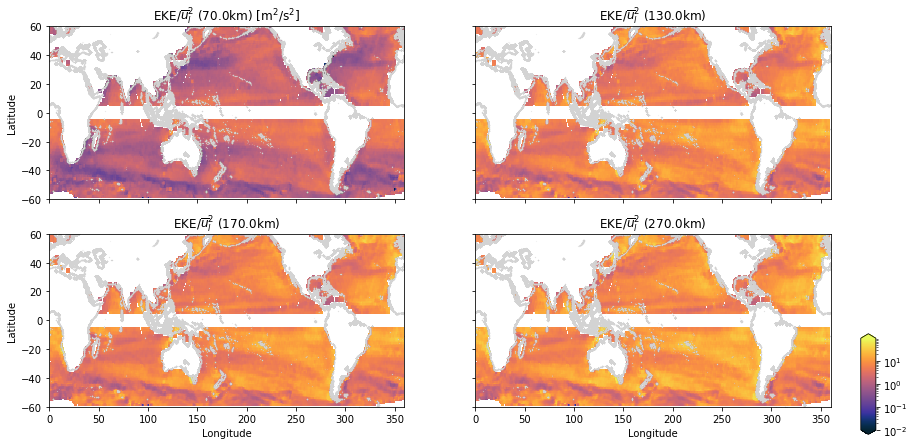

In [222]:
# EKE, MKE, EKE/MKE 
diff_lev1 = np.arange(0.0001, 0.2, 0.0001)
diff_lev1 = np.arange(0.01, 100, 0.1)
tcmap = cmocean.cm.thermal
land_col = '#D3D3D3'

# plot, excluding equator 
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]
mean_v7_mask = np.nanmean(mean_diff0_7, axis=0)/np.nanmean(mean_sla_smooth7, axis=0)
mean_v7_mask[:, v_in] = np.nan
mean_v8_mask = np.nanmean(mean_diff0_8, axis=0)/np.nanmean(mean_sla_smooth8, axis=0)
mean_v8_mask[:, v_in] = np.nan
mean_v9_mask = np.nanmean(mean_diff0_9, axis=0)/np.nanmean(mean_sla_smooth9, axis=0)
mean_v9_mask[:, v_in] = np.nan
mean_v10_mask = np.nanmean(mean_diff0_10, axis=0)/np.nanmean(mean_sla_smooth10, axis=0)
mean_v10_mask[:, v_in] = np.nan
mean_v11_mask = np.nanmean(mean_diff0_11, axis=0)/np.nanmean(mean_sla_smooth11, axis=0)
mean_v11_mask[:, v_in] = np.nan
mean_v12_mask = np.nanmean(mean_diff0_12, axis=0)/np.nanmean(mean_sla_smooth12, axis=0)
mean_v12_mask[:, v_in] = np.nan
mean_v13_mask = np.nanmean(mean_diff0_13, axis=0)/np.nanmean(mean_sla_smooth13, axis=0)
mean_v13_mask[:, v_in] = np.nan

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14, 7))

ax1.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_v7_mask), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla), levels=diff_lev, cmap=tcmap, linewidths=0.5)
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
# ax1.set_xlim([250, lon_e])
# ax1.set_ylim([0, lat_n])
ax1.set_title(r"EKE/$\overline{u}^2_{l}$ (" + str(band_ends[0]) + "km) [m$^2$/s$^2$]")
ax1.set_ylabel('Latitude')

ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v9_mask), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_diff0), levels=diff_lev, cmap=tcmap, linewidths=0.5)
ax2.set_title(r"EKE/$\overline{u}^2_{l}$ (" + str(band_ends[2]) + "km)")

ax3.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_v10_mask), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
ax3.set_title(r"EKE/$\overline{u}^2_{l}$ (" + str(band_ends[3]) + "km)")
ax3.set_ylabel('Latitude')
ax3.set_xlabel('Longitude')

ax4.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax4.pcolor(lon_bins, lat_bins, np.transpose(mean_v12_mask), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
ax4.set_title(r"EKE/$\overline{u}^2_{l}$ (" + str(band_ends[5]) + "km)")
ax4.set_xlabel('Longitude')

# ax5.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax5.pcolor(lon_bins, lat_bins, np.transpose(mean_v11_mask), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
# ax5.set_title(r"$\overline{u}^2_{l}$ (" + str(band_ends[4]) + "km)")

# ax6.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax6.pcolor(lon_bins, lat_bins, np.transpose(mean_v12_mask), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
# ax6.set_title(r"$\overline{u}^2_{l}$ (" + str(band_ends[5]) + "km)")

# ax7.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax7.pcolor(lon_bins, lat_bins, np.transpose(mean_v13_mask), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
# ax7.set_title(r"$\overline{u}^2_{l}$ (" + str(band_ends[6]) + "km)")
# ax7.set_xlabel('Longitude')
# ax7.set_ylabel('Latitude')

cbpos = [0.93, 0.07, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

plt.show()
# f.savefig(this_sat + '_sla_scales.jpg', dpi=400)
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_mke.jpg', dpi=500)

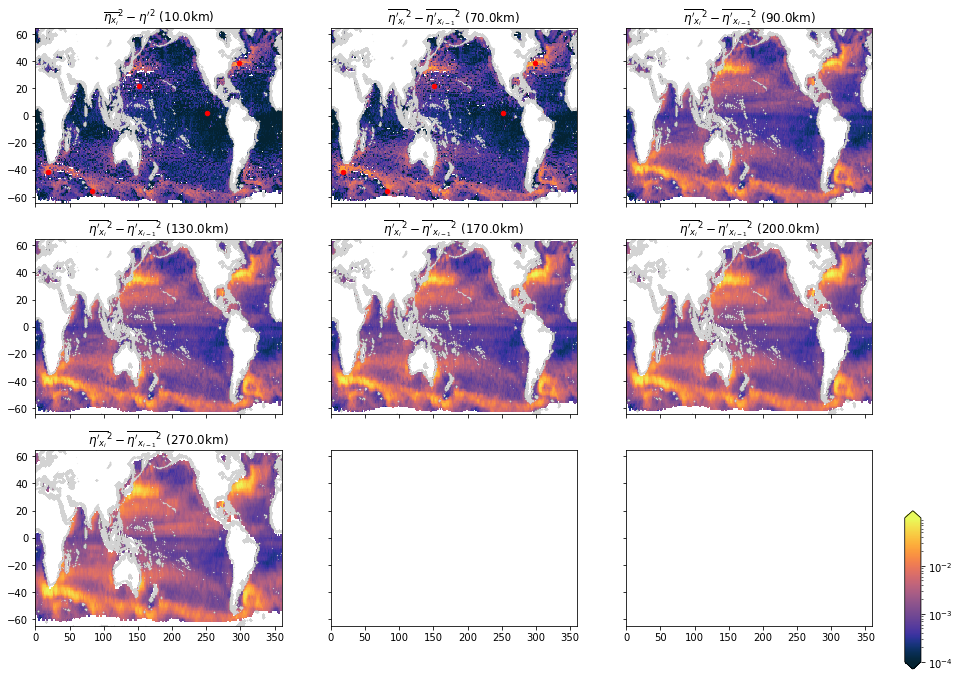

In [51]:
# SUMMER 
diff_lev = np.arange(0.00001, 0.01, 0.00001)
diff_lev1 = np.arange(0.0001, .1, 0.0001)
# diff_lev = np.arange(0.0005, 0.1, 0.0001)
tcmap = cmocean.cm.thermal
land_col = '#D3D3D3'

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, \
                                                                      sharex=True, sharey=True, \
                                                                      figsize=(15, 10))

ax1.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1_7), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla), levels=diff_lev, cmap=tcmap, linewidths=0.5)
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
# ax1.set_xlim([250, lon_e])
# ax1.set_ylim([0, lat_n])
ax1.set_title(r"$\overline{\eta^2}_{l} - \overline{\eta}^2_{l}$ (" + str(hor_grid_spacing) + "km)")
ax1.scatter(loc_points[0][1], loc_points[0][0], s=20, color='r', zorder=2)
ax1.scatter(loc_points[1][1], loc_points[1][0], s=20, color='r', zorder=2)
ax1.scatter(loc_points[2][1], loc_points[2][0], s=20, color='r', zorder=2)
ax1.scatter(loc_points[3][1], loc_points[3][0], s=20, color='r', zorder=2)
ax1.scatter(loc_points[4][1], loc_points[4][0], s=20, color='r', zorder=2)
ax1.set_ylabel('Latitude')

ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1_8), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_diff0), levels=diff_lev, cmap=tcmap, linewidths=0.5)
ax2.set_title(r"$\overline{\eta^2}_{l} - \overline{\eta}^2_{l}$ (" + str(band_ends[0]) + "km)")
ax2.scatter(loc_points[0][1], loc_points[0][0], s=20, color='r', zorder=2)
ax2.scatter(loc_points[1][1], loc_points[1][0], s=20, color='r', zorder=2)
ax2.scatter(loc_points[2][1], loc_points[2][0], s=20, color='r', zorder=2)
ax2.scatter(loc_points[3][1], loc_points[3][0], s=20, color='r', zorder=2)
ax2.scatter(loc_points[4][1], loc_points[4][0], s=20, color='r', zorder=2)

ax3.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1_9), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
ax3.set_title(r"$\overline{\eta^2}_{l} - \overline{\eta}^2_{l}$ (" + str(band_ends[1]) + "km)")

ax4.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax4.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1_10), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
ax4.set_title(r"$\overline{\eta^2}_{l} - \overline{\eta}^2_{l}$ (" + str(band_ends[2]) + "km)")
ax4.set_ylabel('Latitude')

ax5.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax5.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1_11), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
ax5.set_title(r"$\overline{\eta^2}_{l} - \overline{\eta}^2_{l}$ (" + str(band_ends[3]) + "km)")

ax6.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax6.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1_12), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
ax6.set_title(r"$\overline{\eta^2}_{l} - \overline{\eta}^2_{l}$ (" + str(band_ends[4]) + "km)")

ax7.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax7.pcolor(lon_bins, lat_bins, np.transpose(mean_diff1_13), norm=LogNorm(vmin=diff_lev1[0], vmax=diff_lev1[-1]), zorder=0, cmap=tcmap)
ax7.set_title(r"$\overline{\eta^2}_{l} - \overline{\eta}^2_{l}$ (" + str(band_ends[5]) + "km)")
ax7.set_xlabel('Longitude')
ax7.set_ylabel('Latitude')

cbpos = [0.93, 0.07, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

plt.show()
# f.savefig(this_sat + '_sla_band_pass.jpg', dpi=500)

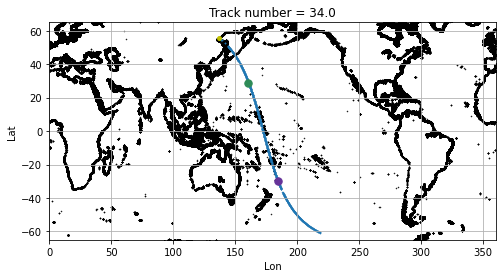

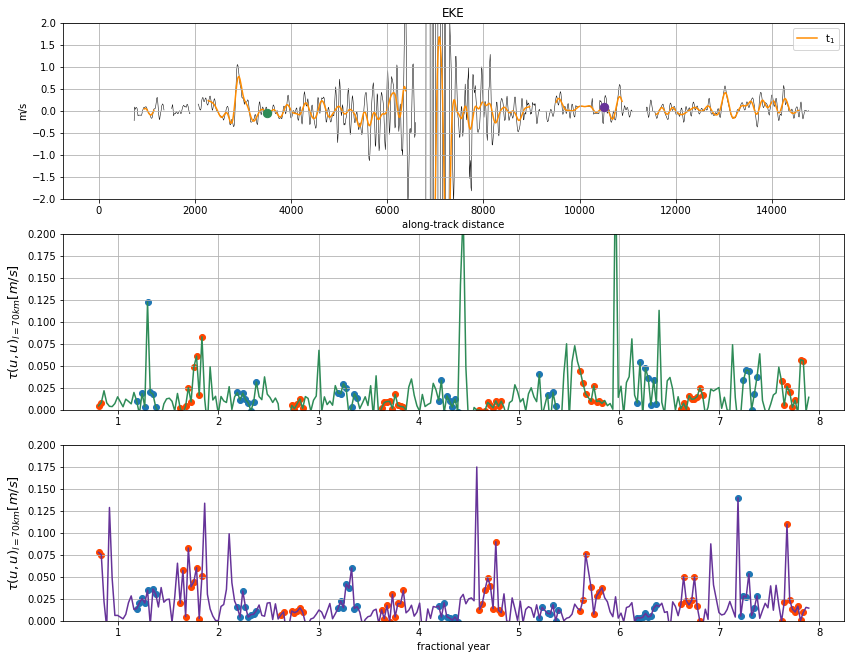

In [92]:
# check why do I see seasonality? 
ii = 33  # 23, 32
ii_2 = 99
disti = 350  # 450
disti2 = 1050  # 1300
# disti = np.where((lat_record[ii] > 29) & (lat_record[ii] < 30))[0]

this_time = np.mod(year_time_record[ii], 1)
time_in_w = np.where((this_time > winter_season[0]) & (this_time < winter_season[1]))[0]
time_in_s = np.where((this_time > summer_season[0]) & (this_time < summer_season[1]))[0]

f, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
ax.scatter(lon_record[ii], lat_record[ii], s=0.25)
ax.scatter(lon_record[ii][0], lat_record[ii][0], s=15, color='y')
ax.scatter(lon_record[ii][disti], lat_record[ii][disti], s=55, color='#2E8B57', zorder=2)
ax.scatter(lon_record[ii][disti2], lat_record[ii][disti2], s=55, color='#663399', zorder=2)
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title('Track number = ' + str(track_record[ii]))
ax.grid()
plt.show()
# f.savefig(this_sat + '_test_track.jpg', dpi=500)
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_time_series_loc.jpg', dpi=500)

f, (ax0, ax, ax2) = plt.subplots(3,1,figsize=(14,11))
ax0.plot(dist[ii], sla[ii][5, :], color='k', linewidth=0.5, zorder=0)
ax0.plot(dist[ii], sla_s_dict[-1][ii][5, :], label='t$_1$', zorder=1, color='#FF8C00')
ax0.scatter(dist[ii][disti], sla_s_dict[-1][ii][5, disti], s=70, color='#2E8B57', zorder=2)
ax0.scatter(dist[ii][disti2], sla_s_dict[-1][ii][5, disti2], s=70, color='#663399', zorder=2)
# ax0.plot(dist[ii], sla_s_dict[6][ii][6, :], label='t$_2$')
# ax0.scatter(dist[ii][disti], sla_s_dict[6][ii][6, disti], s=50, color='#2E8B57')
# ax0.scatter(dist[ii][disti2], sla_s_dict[6][ii][6, disti2], s=50, color='#663399')
ax0.set_title('EKE')
ax0.set_xlabel('along-track distance')
ax0.set_ylabel('m/s')
ax0.set_ylim([-2, 2])
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=10)
ax0.grid()

# ax.plot(year_time_record[ii], \
#         np.nanmean(np.concatenate((sla_s_dict[6][ii][:, disti][:, None]**2, sla_s_dict[6][ii_2][:, disti][:, None]**2), axis=1), axis=1), color='#2E8B57')
ax.plot(year_time_record[ii], 
        sla_sq_s_dict[-1][ii][:, disti] - (sla_s_dict[-1][ii][:, disti]**2), color='#2E8B57')
ax.scatter(year_time_record[ii][time_in_w], \
           sla_sq_s_dict[-1][ii][time_in_w, disti] - sla_s_dict[-1][ii][time_in_w, disti]**2)
ax.scatter(year_time_record[ii][time_in_s], \
           sla_sq_s_dict[-1][ii][time_in_s, disti] - sla_s_dict[-1][ii][time_in_s, disti]**2, color='#FF4500')
ax.set_ylabel(r'$\tau (u,u)_{l=70km} [m/s]$', fontsize=13)
ax.set_ylim([0, .2])
ax.grid()

ax2.plot(year_time_record[ii], sla_sq_s_dict[-1][ii][:, disti2] - sla_s_dict[6][ii][:, disti2]**2, color='#663399')
ax2.scatter(year_time_record[ii][time_in_w], sla_sq_s_dict[-1][ii][time_in_w, disti2] - sla_s_dict[-1][ii][time_in_w, disti2]**2)
ax2.scatter(year_time_record[ii][time_in_s], sla_sq_s_dict[-1][ii][time_in_s, disti2] - sla_s_dict[-1][ii][time_in_s, disti2]**2, color='#FF4500')
ax2.set_xlabel('fractional year')
ax2.set_ylabel(r'$\tau (u,u)_{l=70km} [m/s]$', fontsize=13)
ax2.set_ylim([0, .2])
ax2.grid()
plt.show()
# f.savefig(this_sat + '_test_time_variability.jpg', dpi=500)
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_time_series.jpg', dpi=500)

# print(lon_record[ii][disti])
# print(lat_record[ii][disti])
# print(np.nanmean(sla_sq_s_dict[4][ii][time_in_w, disti]) - np.nanmean(sla_sq_s_dict[4][ii][time_in_s, disti]))
# print(np.nanmean(sla_sq_s_dict[4][ii][time_in_w, disti2]) - np.nanmean(sla_sq_s_dict[4][ii][time_in_s, disti2]))

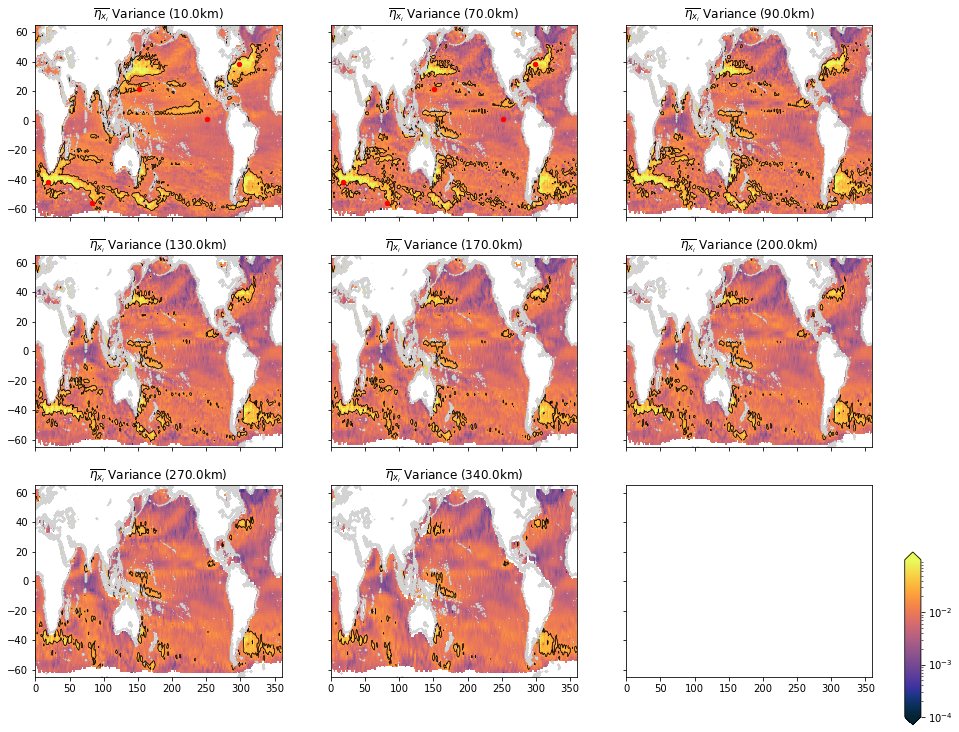

In [63]:
# SLA/ADT Variance at each scale 
diff_lev = np.arange(0.0001, 0.1, 0.0001)
tcmap = cmocean.cm.thermal
land_col = '#D3D3D3'
sing_lev = np.array([0.02, 0.021])
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, \
                                                                                sharex=True, sharey=True, \
                                                                                figsize=(15, 12))

ax1.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_sla), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla), levels=sing_lev, colors='k', linewidths=0.5)
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(hor_grid_spacing) + "km)")
ax1.scatter(loc_points[0][1], loc_points[0][0], s=20, color='r', zorder=2)
ax1.scatter(loc_points[1][1], loc_points[1][0], s=20, color='r', zorder=2)
ax1.scatter(loc_points[2][1], loc_points[2][0], s=20, color='r', zorder=2)
ax1.scatter(loc_points[3][1], loc_points[3][0], s=20, color='r', zorder=2)
ax1.scatter(loc_points[4][1], loc_points[4][0], s=20, color='r', zorder=2)

ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth7), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth7), levels=sing_lev, colors='k', linewidths=0.5)
ax2.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[0]) + "km)")
ax2.scatter(loc_points[0][1], loc_points[0][0], s=20, color='r', zorder=2)
ax2.scatter(loc_points[1][1], loc_points[1][0], s=20, color='r', zorder=2)
ax2.scatter(loc_points[2][1], loc_points[2][0], s=20, color='r', zorder=2)
ax2.scatter(loc_points[3][1], loc_points[3][0], s=20, color='r', zorder=2)
ax2.scatter(loc_points[4][1], loc_points[4][0], s=20, color='r', zorder=2)

ax3.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth8), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
ax3.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth8), levels=sing_lev, colors='k', linewidths=0.5)
ax3.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[1]) + "km)")

ax4.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax4.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth9), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
ax4.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth9), levels=sing_lev, colors='k', linewidths=0.5)
ax4.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[2]) + "km)")

ax5.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax5.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth10), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
ax5.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth10), levels=sing_lev, colors='k', linewidths=0.5)
ax5.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[3]) + "km)")

ax6.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax6.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth11), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
ax6.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth11), levels=sing_lev, colors='k', linewidths=0.5)
ax6.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[4]) + "km)")

ax7.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax7.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth12), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
ax7.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth12), levels=sing_lev, colors='k', linewidths=0.5)
ax7.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[5]) + "km)")

ax8.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax8.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth13), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
ax8.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth13), levels=sing_lev, colors='k', linewidths=0.5)
ax8.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[6]) + "km)")

# ax9.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax9.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth7), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
# ax9.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth7), levels=sing_lev, colors='k', linewidths=0.5)
# ax9.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[7]) + "km)")

# ax10.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax10.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth8), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
# ax10.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth8), levels=sing_lev, colors='k', linewidths=0.5)
# ax10.set_title(r"$\overline{\eta_{x_i}} Variance $ (" + str(band_ends[8]) + "km)")

# ax11.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax11.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth9), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
# ax11.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth9), levels=sing_lev, colors='k', linewidths=0.5)
# ax11.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[9]) + "km)")

# ax12.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
# axp = ax12.pcolor(lon_bins, lat_bins, np.transpose(mean_sla_smooth10), norm=LogNorm(vmin=diff_lev[0], vmax=diff_lev[-1]), zorder=0, cmap=tcmap)
# ax12.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla_smooth10), levels=sing_lev, colors='k', linewidths=0.5)
# ax12.set_title(r"$\overline{\eta_{x_i}}$ Variance (" + str(band_ends[10]) + "km)")

cbpos = [0.93, 0.07, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')

plt.show()
# f.savefig(this_sat + '_sla_band_pass.jpg', dpi=500)